In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import statsmodels.api as sm

from numpy import asarray
from sklearn.preprocessing import MinMaxScaler

from dateutil.relativedelta import relativedelta

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
#pd.reset_option('display.float_format')

In [2]:
data = pd.read_csv("./data/kc_house_data.csv")

# Supporting Functions

In [3]:

def checkForColinearity(df_ColsToCheck):
    df=df_ColsToCheck.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    #zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    #set index to pairs
    df.set_index(['pairs'], inplace = True)

    #drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    #rename correlation column as cc rather than 0
    df.columns = ['cc']

    #drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    df.drop_duplicates(inplace=True)
    df = df[(df.cc>.70) & (df.cc <1)]
    return df

def correlation_heatmap(df):
    _,ax=plt.subplots(figsize=(60,30))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(df.corr(),annot=True,cmap=colormap)

def checkForVIF(df_ColsToCheck):
#     X = df[x_cols]
    vif = [variance_inflation_factor(df_ColsToCheck.values, i) for i in range(df_ColsToCheck.shape[1])]
    vifresults = list(zip(df_ColsToCheck.columns, vif))
    return vifresults

def scaleData_min_max (df_continuous):
    scaler = MinMaxScaler()
    # transform data
    scaler_a = MinMaxScaler().fit(df_continuous)
    scaler_ = scaler.fit_transform(df_continuous)
    scaled_df = pd.DataFrame(scaler_, columns=df_continuous.columns)
    scaled_df_no_index = scaled_df.reset_index(drop=True)
    #
    return scaled_df_no_index, scaler_a

# Preprocessing

Ensure No Missing Values

waterfront      2376
view              63
yr_renovated    3842
dtype: int64


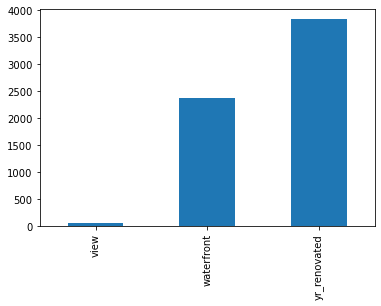

In [4]:
missing = data.isnull().sum()
missing = missing[missing > 0]
print (missing)
missing.sort_values(inplace=True)
missing.plot.bar();

### Dealing with Missing Values

In [5]:
#fill In Waterfront and View Nulls
data_No_NAs = data
data_No_NAs['waterfront'].fillna(data['waterfront'].mode()[0], inplace=True)
data_No_NAs['view'].fillna(data['view'].mode()[0], inplace=True)


#fill In Year Renovated and insert "Age of Home" (Today - Year Built) and "Years Since Renovated"
data_No_NAs["yr_renovated"].fillna(0, inplace=True)
# data_No_NAs["yr_renovated"]  = data_No_NAs.apply(lambda row : (row['yr_built']) if row["yr_renovated"] == 0 else row["yr_renovated"], axis=1)

#handle "?" in the sqrt basement column
data_No_NAs["sqft_basement"]  = data_No_NAs.apply(lambda row : 0 if row["sqft_basement"] == "?" else row["sqft_basement"], axis=1)
data_No_NAs["sqft_basement"] = data_No_NAs["sqft_basement"].astype('float')


### Add Potential Interesting Columns using basedata

In [6]:
#Any relationship if renovated
data_No_NAs["If_renovated"]  = data_No_NAs.apply(lambda row : 1 if row["yr_renovated"] > 0 else 0, axis=1)


# Any relatinship with age of home
data_No_NAs["AgeOfHome"] = (2020 - data_No_NAs["yr_built"])

# Is there any relationship with zipcode
data_No_NAs["zipcode_str"] = data_No_NAs["zipcode"].astype('str')
data_No_NAs['ZipFirst3'] = data_No_NAs["zipcode_str"].str[:3]
data_No_NAs['ZipFirst3_int'] = data_No_NAs["ZipFirst3"].astype('int')
data_No_NAs = data_No_NAs.drop("zipcode_str", axis=1) 

# Is there any relationship with the month of sale?
data_No_NAs['salesyear'] = pd.DatetimeIndex(data_No_NAs['date']).year
data_No_NAs['sls_month'] = pd.DatetimeIndex(data_No_NAs['date']).month
                                                 
                                                 
# Create new variables Rooms and sqft_Above_Combo given high vifs
data_No_NAs["ttl_rooms"] = data_No_NAs['bedrooms']*data_No_NAs['bathrooms']

In [7]:
missing = data_No_NAs.isnull().sum()
missing

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
If_renovated     0
AgeOfHome        0
ZipFirst3        0
ZipFirst3_int    0
salesyear        0
sls_month        0
ttl_rooms        0
dtype: int64

# <u> <font color='red'>Model 1 Dataset</font></u>

##    Creating Inital Dataset

## Looking for Linear Relationships, Drop Features With Low Relationship, Scale

### Transform target and remove outliers to improve linearity

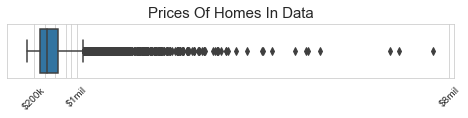

In [8]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_No_NAs['price'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
           labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

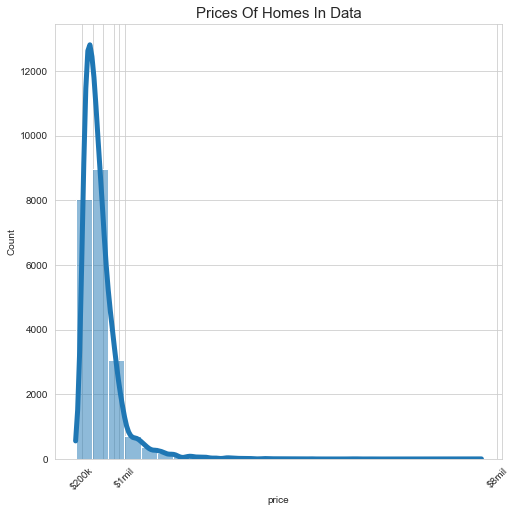

In [9]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
plt.title('Prices Of Homes In Data', fontsize=15)
sns.histplot(x= "price",
             data=data_No_NAs,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
           labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

Big Spead in Homes Prices.  Look to remove outliers

In [10]:
# View Inter quartile Range
q_high = data_No_NAs['price'].quantile(.75)
q_low = data_No_NAs['price'].quantile(.25)
print(f' Lower Range - ${q_low} , Upper Range - ${q_high}')

 Lower Range - $322000.0 , Upper Range - $645000.0


Given Heavy skew right, going to log transform and then drop outliers prices based on log transformation

In [11]:
data_No_NAs["log_price"] = np.log(data_No_NAs['price'])

<ipython-input-12-2db5c8e7d4c8>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


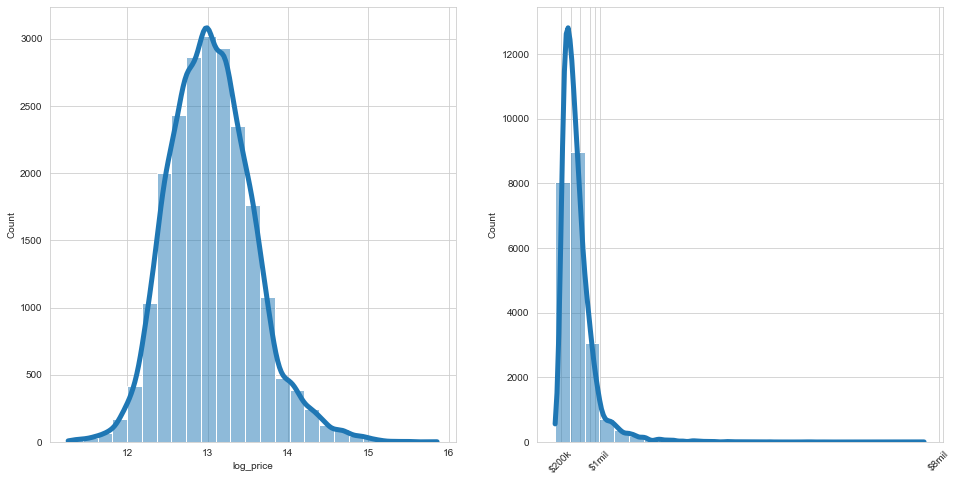

In [12]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

# fig = plt.figure(figsize = (8,8))

sns.histplot(data_No_NAs['log_price'], ax=ax, bins=25,
             kde=True,
             line_kws={"linewidth":5})

plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
                 labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'), rotation=45)
plt.xlabel('', fontsize=15)

# plt.set(ax.get_xticklabels(), rotation=45)
# ax.set_xlabel('')

sns.histplot(data_No_NAs['price'], ax=ax2, bins=25,
             kde=True,
             line_kws={"linewidth":5})

plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
                 labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'), rotation=45)
plt.xlabel('', fontsize=15)
fig.show()

Target feature now looks more normalized, now drop outlines

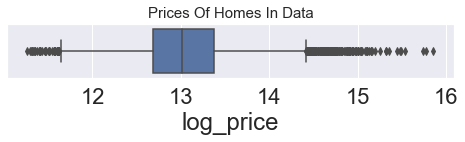

In [13]:
sns.set_style('whitegrid')
sns.set(font_scale=2)
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_No_NAs['log_price'], labels=None)
plt.show();

In [14]:
#Parmameters, # lower = 244999, upper = $886999 12.409013489526863 # 13.695600261291716
# print(np.exp(Q1))

q_low = data_No_NAs['log_price'].quantile(0.1)
q_high = data_No_NAs['log_price'].quantile(0.9)

data_Target_Homes = data_No_NAs[data_No_NAs['log_price']<q_high]
data_Target_Homes = data_Target_Homes[data_Target_Homes['log_price']>q_low]

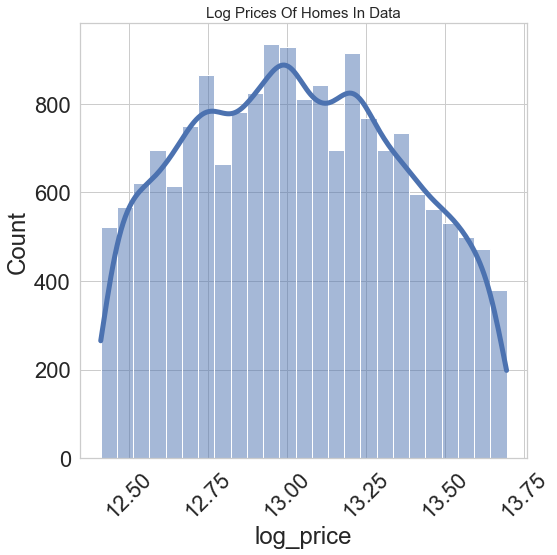

In [15]:
#Veiw price once log transformed
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
plt.title('Log Prices Of Homes In Data', fontsize=15)
sns.histplot(x= "log_price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )

plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

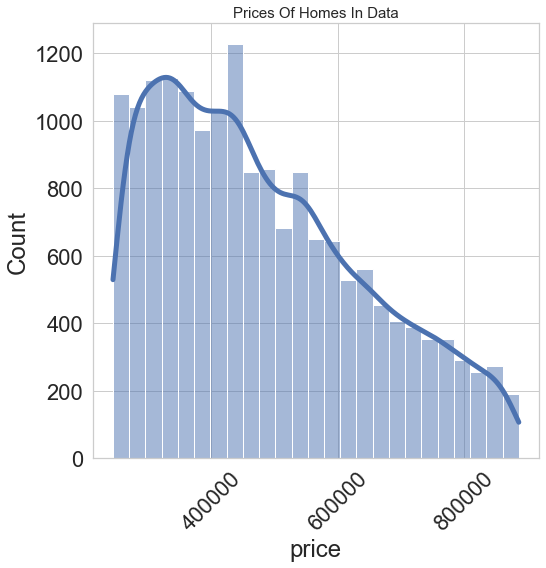

In [16]:
#Veiw distribution in real $ after removing outliers 
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
plt.title('Prices Of Homes In Data', fontsize=15)
sns.histplot(x= "price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
# plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000), 
#            labels= ('$200k', '', '', '',
#                     '', '$1mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

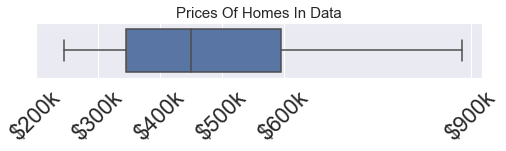

In [17]:
sns.set_style('whitegrid')
sns.set(font_scale=2)
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_Target_Homes['price'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
plt.xticks(ticks=(200000, 300000, 400000, 500000,600000, 900000), 
           labels= ('$200k','$300k', '$400k', '$500k','$600k','$900k'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

Examin features for outliers

In [18]:
ColsToCheckForOutliers = data_Target_Homes[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'AgeOfHome','ttl_rooms']]

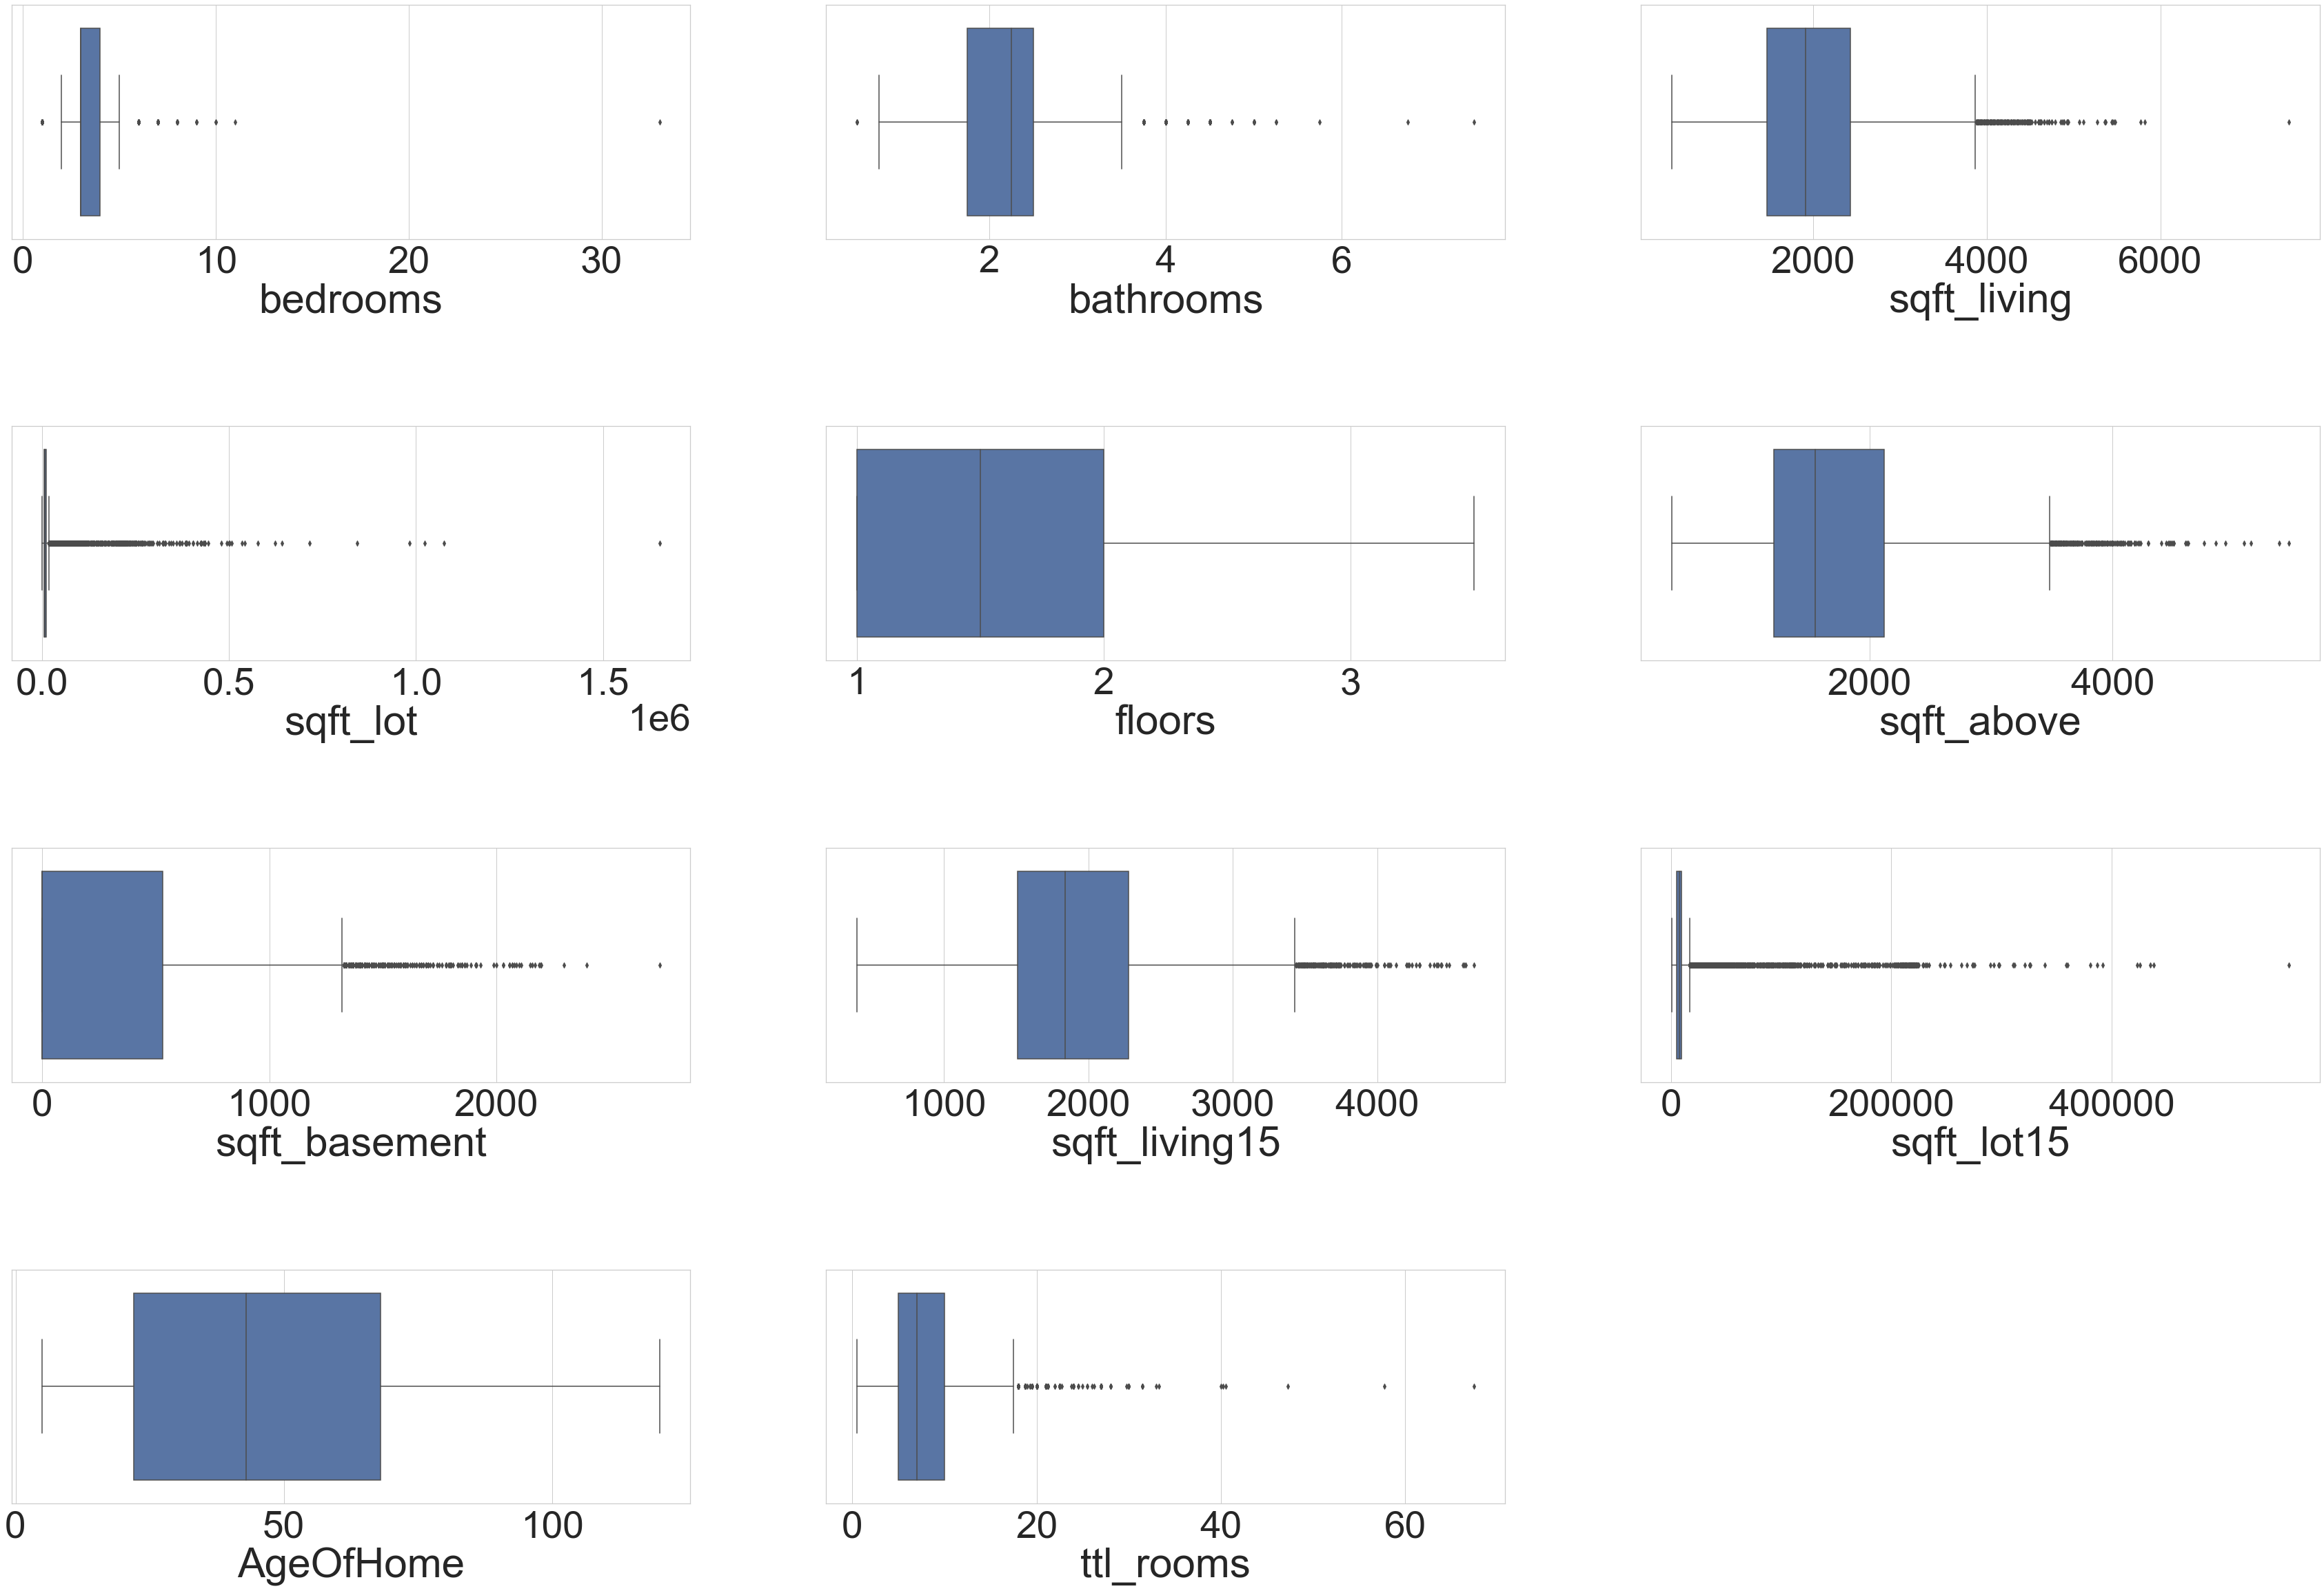

In [19]:
plt.figure(figsize=(60,40), facecolor="white")
plt.subplots_adjust(hspace = 0.8)
sns.set_style('whitegrid')
sns.set(font_scale=5)
sns.set_style("whitegrid")
for index, column in enumerate(ColsToCheckForOutliers):

    if column != "price":
        ax = plt.subplot(4, 3, index+1)
        sns.boxplot(x=column, data=ColsToCheckForOutliers, ax=ax);
         
plt.show();


Remove additional outliers Ex. bedrooms = 33 , Bathrooms < 8, Sqft_Lot <10000. > 4000, Homes that have sold more than 1 on target years

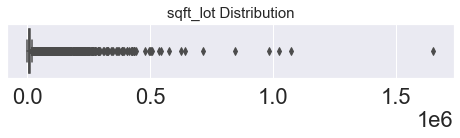

In [20]:
# Review sgft lot, Something looks off, Need to zoom in
sns.set_style('whitegrid')
sns.set(font_scale=2)
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('sqft_lot Distribution', fontsize=15)
sns.boxplot(x=data_Target_Homes['sqft_lot'], labels=None)
ax.set_xlabel('')
plt.show();

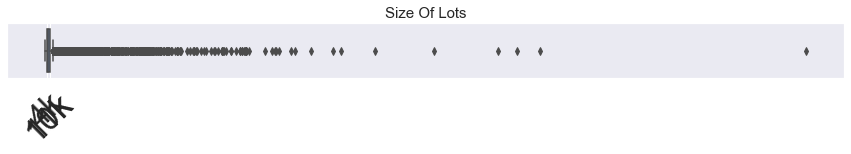

In [21]:
sns.set_style('whitegrid')
sns.set(font_scale=3)
fig,ax=plt.subplots(1,1,figsize=(15,1))
plt.title('Size Of Lots', fontsize=15)
sns.boxplot(x=data_Target_Homes['sqft_lot'], labels=None)
plt.xticks(ticks=(4000, 10000, 11000), 
           labels= ('4k','10k','11k'))
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

#Remove outliers and perform again 

In [22]:
#Keep homes that have bewteen 1-6 bathrooms
data_Target_Homes = data_Target_Homes.loc[(1<= data_Target_Homes['bathrooms']) & (data_Target_Homes['bathrooms'] <= 6)]  # > 6 Bathrooms

#Keep homes between 1 - 10 bedrooms < 10
data_Target_Homes = data_Target_Homes.loc[(1<= data_Target_Homes['bedrooms']) & (data_Target_Homes['bedrooms'] <= 10)]  # > 6 Bathrooms

#Keep lots between 4000 and 12000 ft
data_Target_Homes = data_Target_Homes.loc[(4000 <= data_Target_Homes['sqft_lot']) & (data_Target_Homes['sqft_lot'] <= 10000)] #4000, 12000


data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['sqft_above'] >= 700]

# Keep homes with finished basements or are waterfront
data_Target_Homes = data_Target_Homes.loc[(data_Target_Homes['sqft_basement'] >100) | (data_Target_Homes['waterfront']==1)]

In [23]:
#Remove Homes That have sold More Than Twice In the Same year (Flipper Homes)
df_housesThatSoldTwice = data_Target_Homes.groupby('id').count().reset_index().sort_values(by="date", ascending=False)
df_housesThatSoldTwice = df_housesThatSoldTwice[df_housesThatSoldTwice["date"] > 1]
data_Target_Homes = data_Target_Homes.merge(df_housesThatSoldTwice[['id','date']], on="id", how='left')
data_Target_Homes.date_y.fillna(0, inplace=True)
data_Target_Homes = data_Target_Homes[data_Target_Homes["date_y"]==0]
data_Target_Homes = data_Target_Homes.drop(['date_y'], axis=1)
data_Target_Homes.rename(columns={"date_x":"date"}, inplace=True)

In [24]:
#Create Pickel of data before transforming dummies, needed to create visuals for recommendation 1
with open('./data/PickleFiles/data_Target_Homes.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes, f)

###Review Linearity

In [25]:
CheckForlinearity = data_Target_Homes.drop(columns=['id','date','long', 'ZipFirst3', 'log_price'])

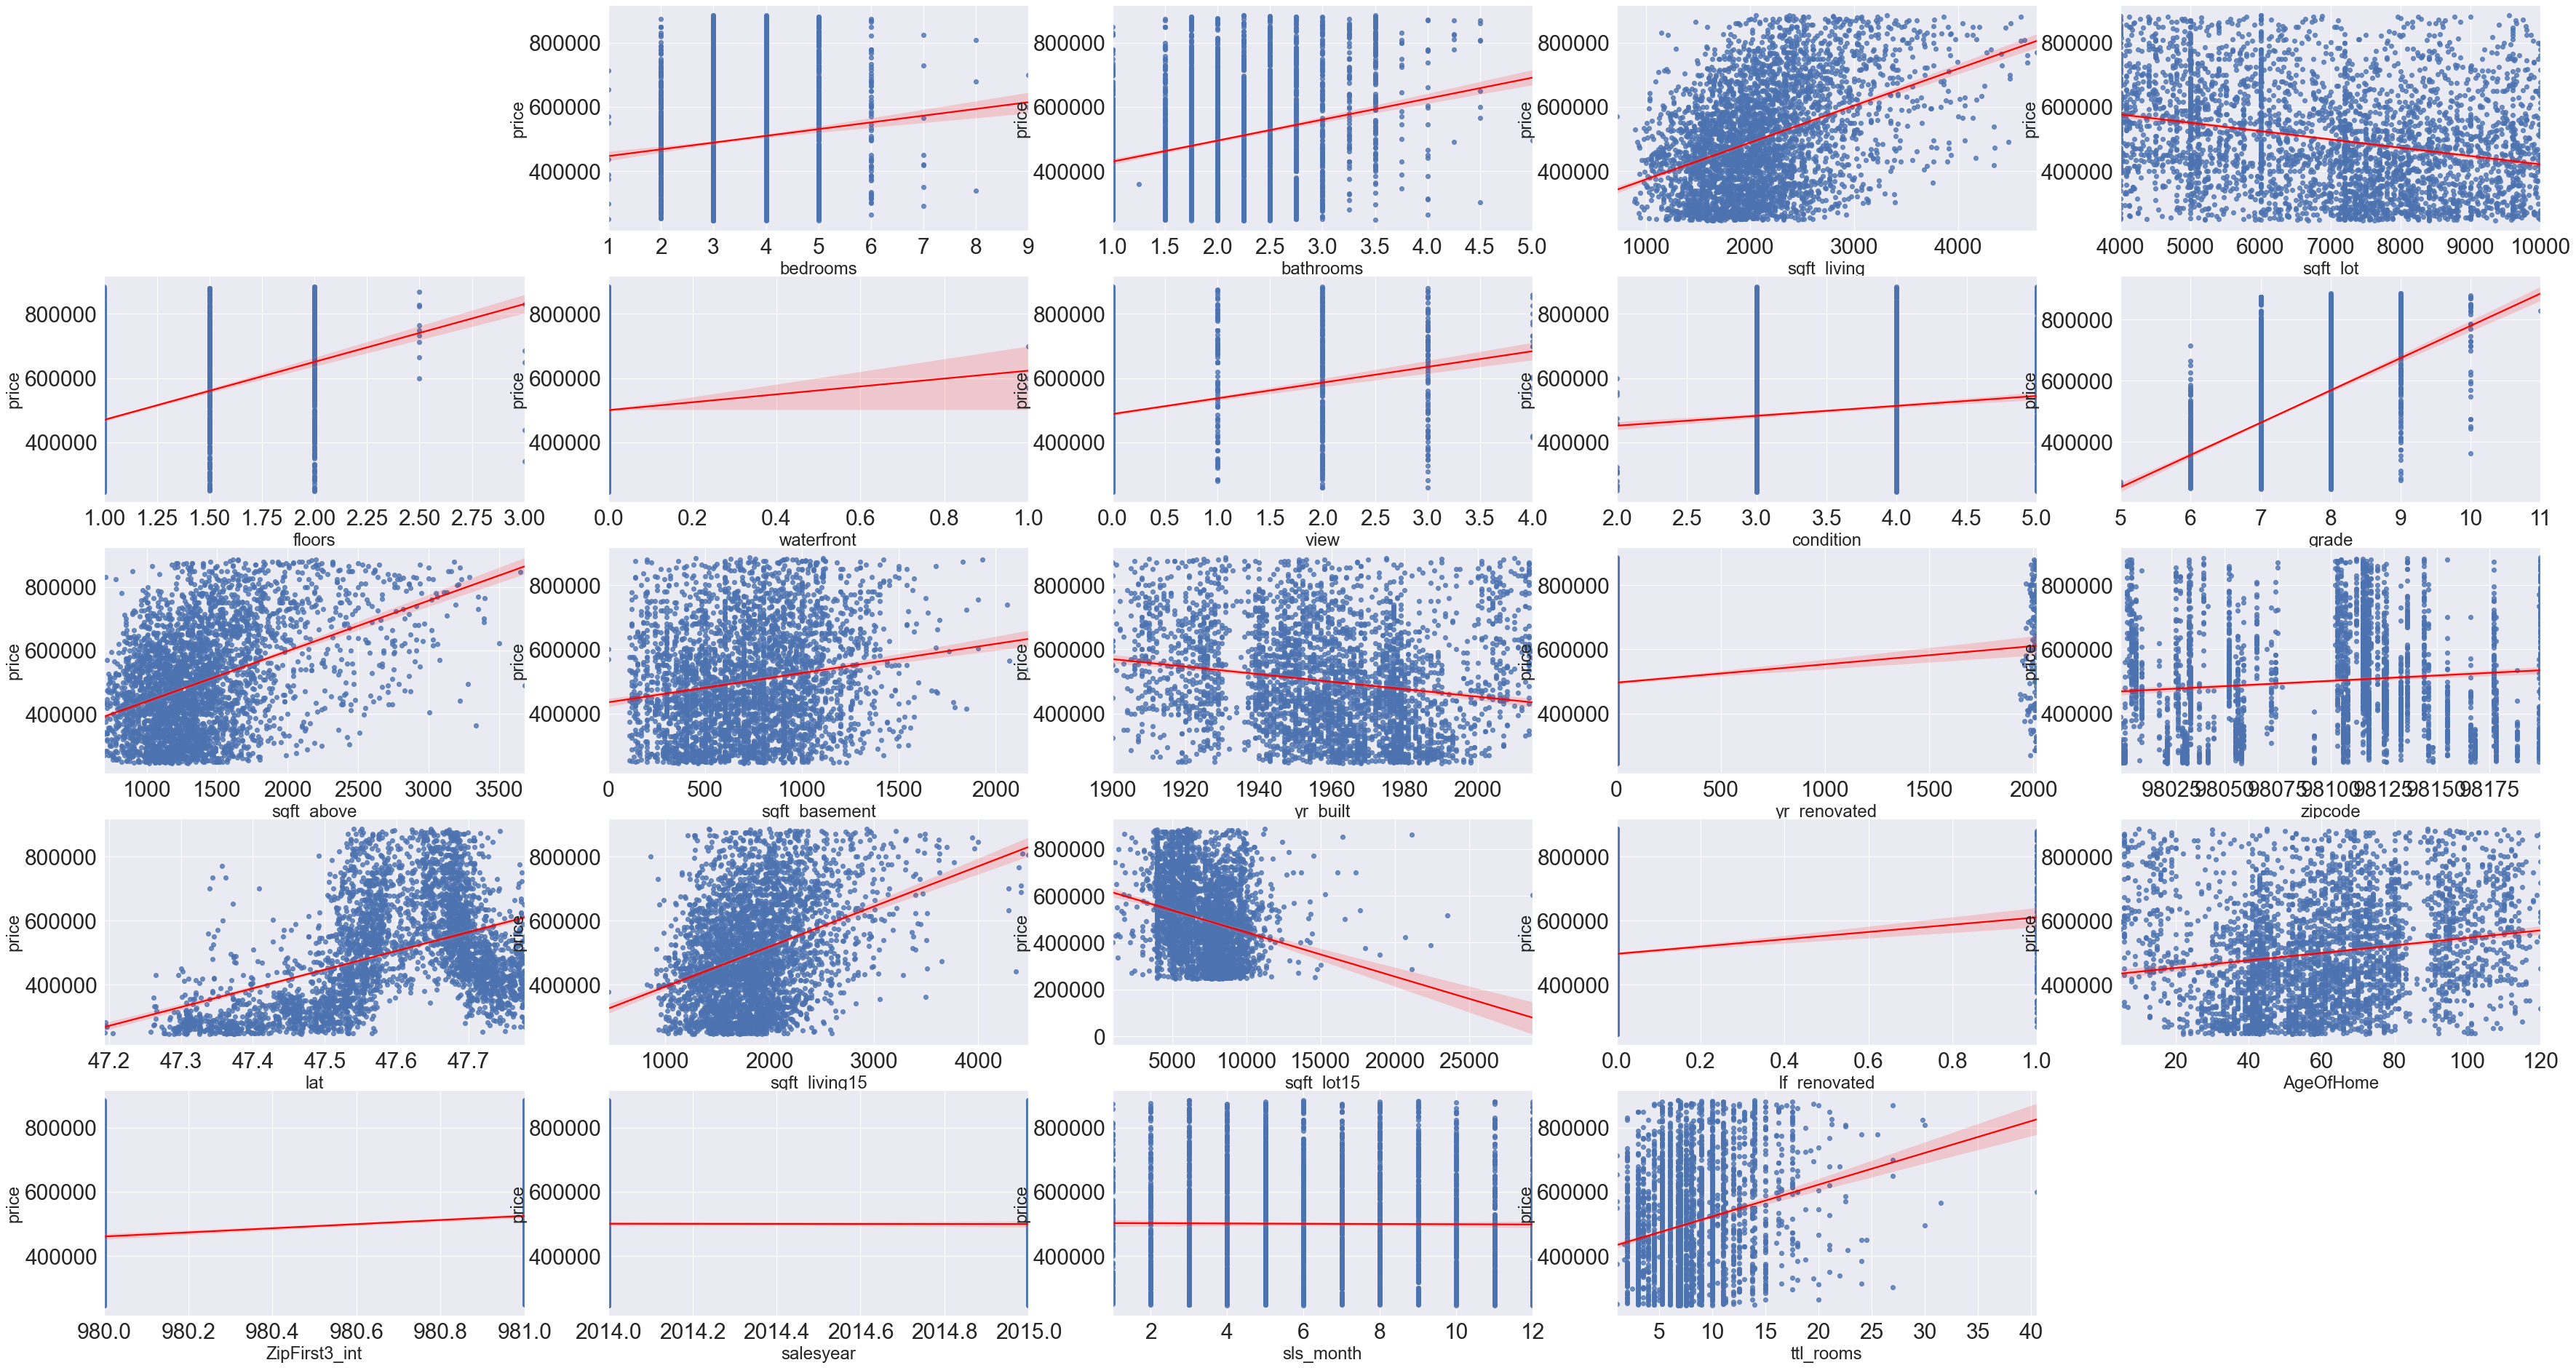

In [26]:
plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)

for index, column in enumerate(CheckForlinearity):

    if column != "price":
        ax = plt.subplot(6, 5, index+1)
        sns.regplot(x=column, y="price", data=CheckForlinearity, ax=ax, label='medium', line_kws={"color": "red"});
        plt.ticklabel_format(style='plain', axis='both')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
    
plt.show();

Get a closer look at a few of the future categoricals

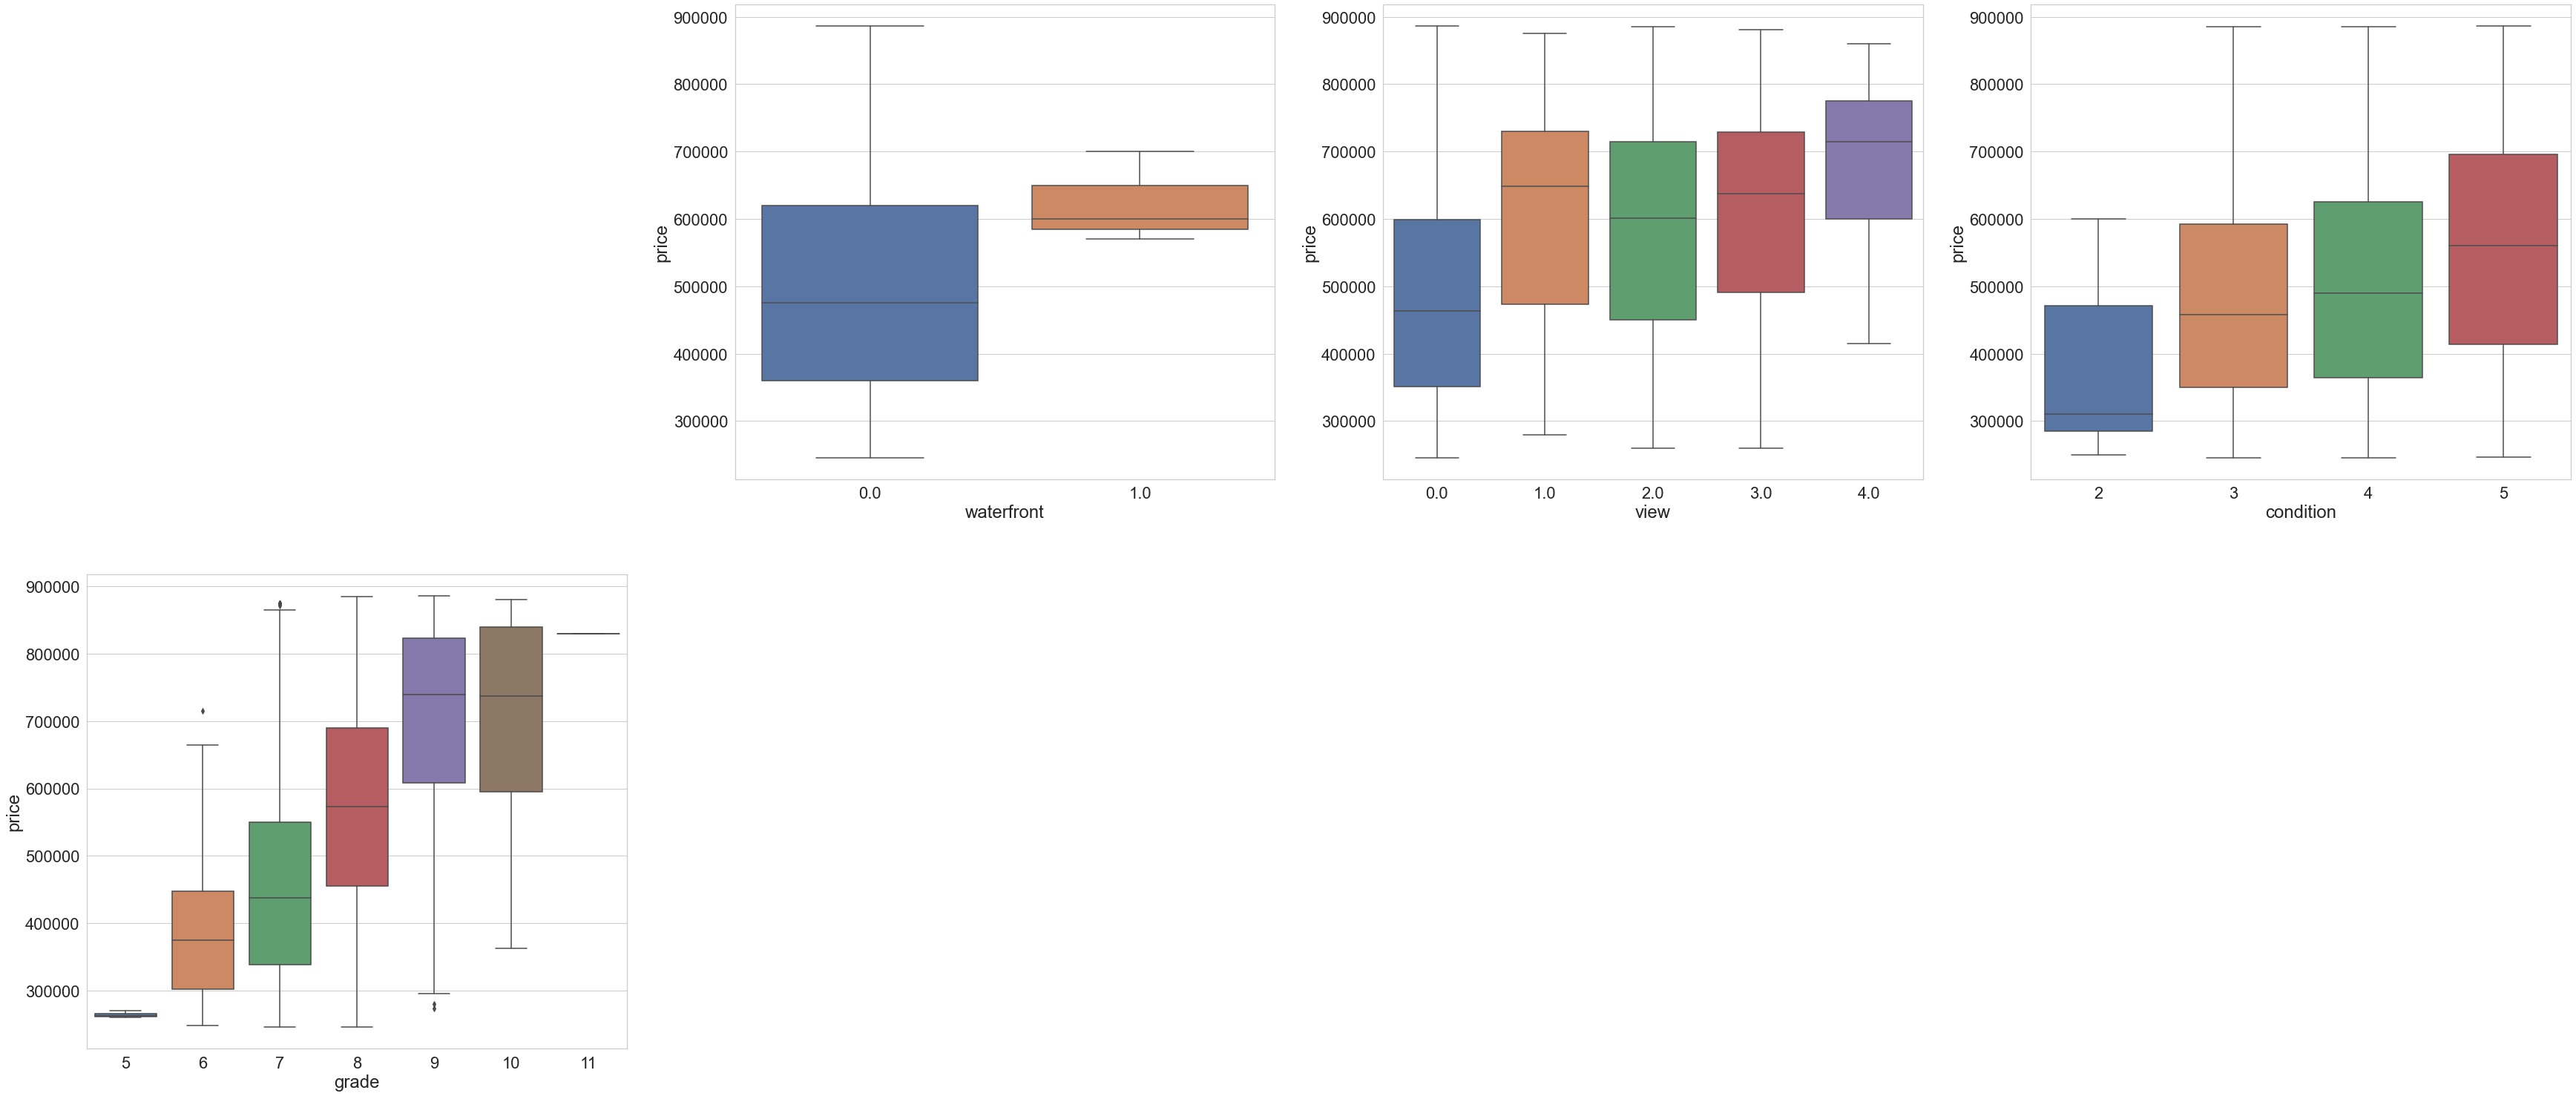

In [27]:

CategoricalsToCheck  = ['price','waterfront', 'view', 'condition', 'grade']


CheckForlinearity1 = CheckForlinearity[CategoricalsToCheck]

plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)
sns.set_style("whitegrid")
for index, column in enumerate(CheckForlinearity1):

    if column != "price":
        ax = plt.subplot(3, 4, index+1)
#         sns.boxplot(x=data_Target_Homes['grade'],y=data_Target_Homes['price'],ax=ax[0])
        sns.boxplot(x=column, y="price", data=CheckForlinearity1, ax=ax);
    
plt.show();

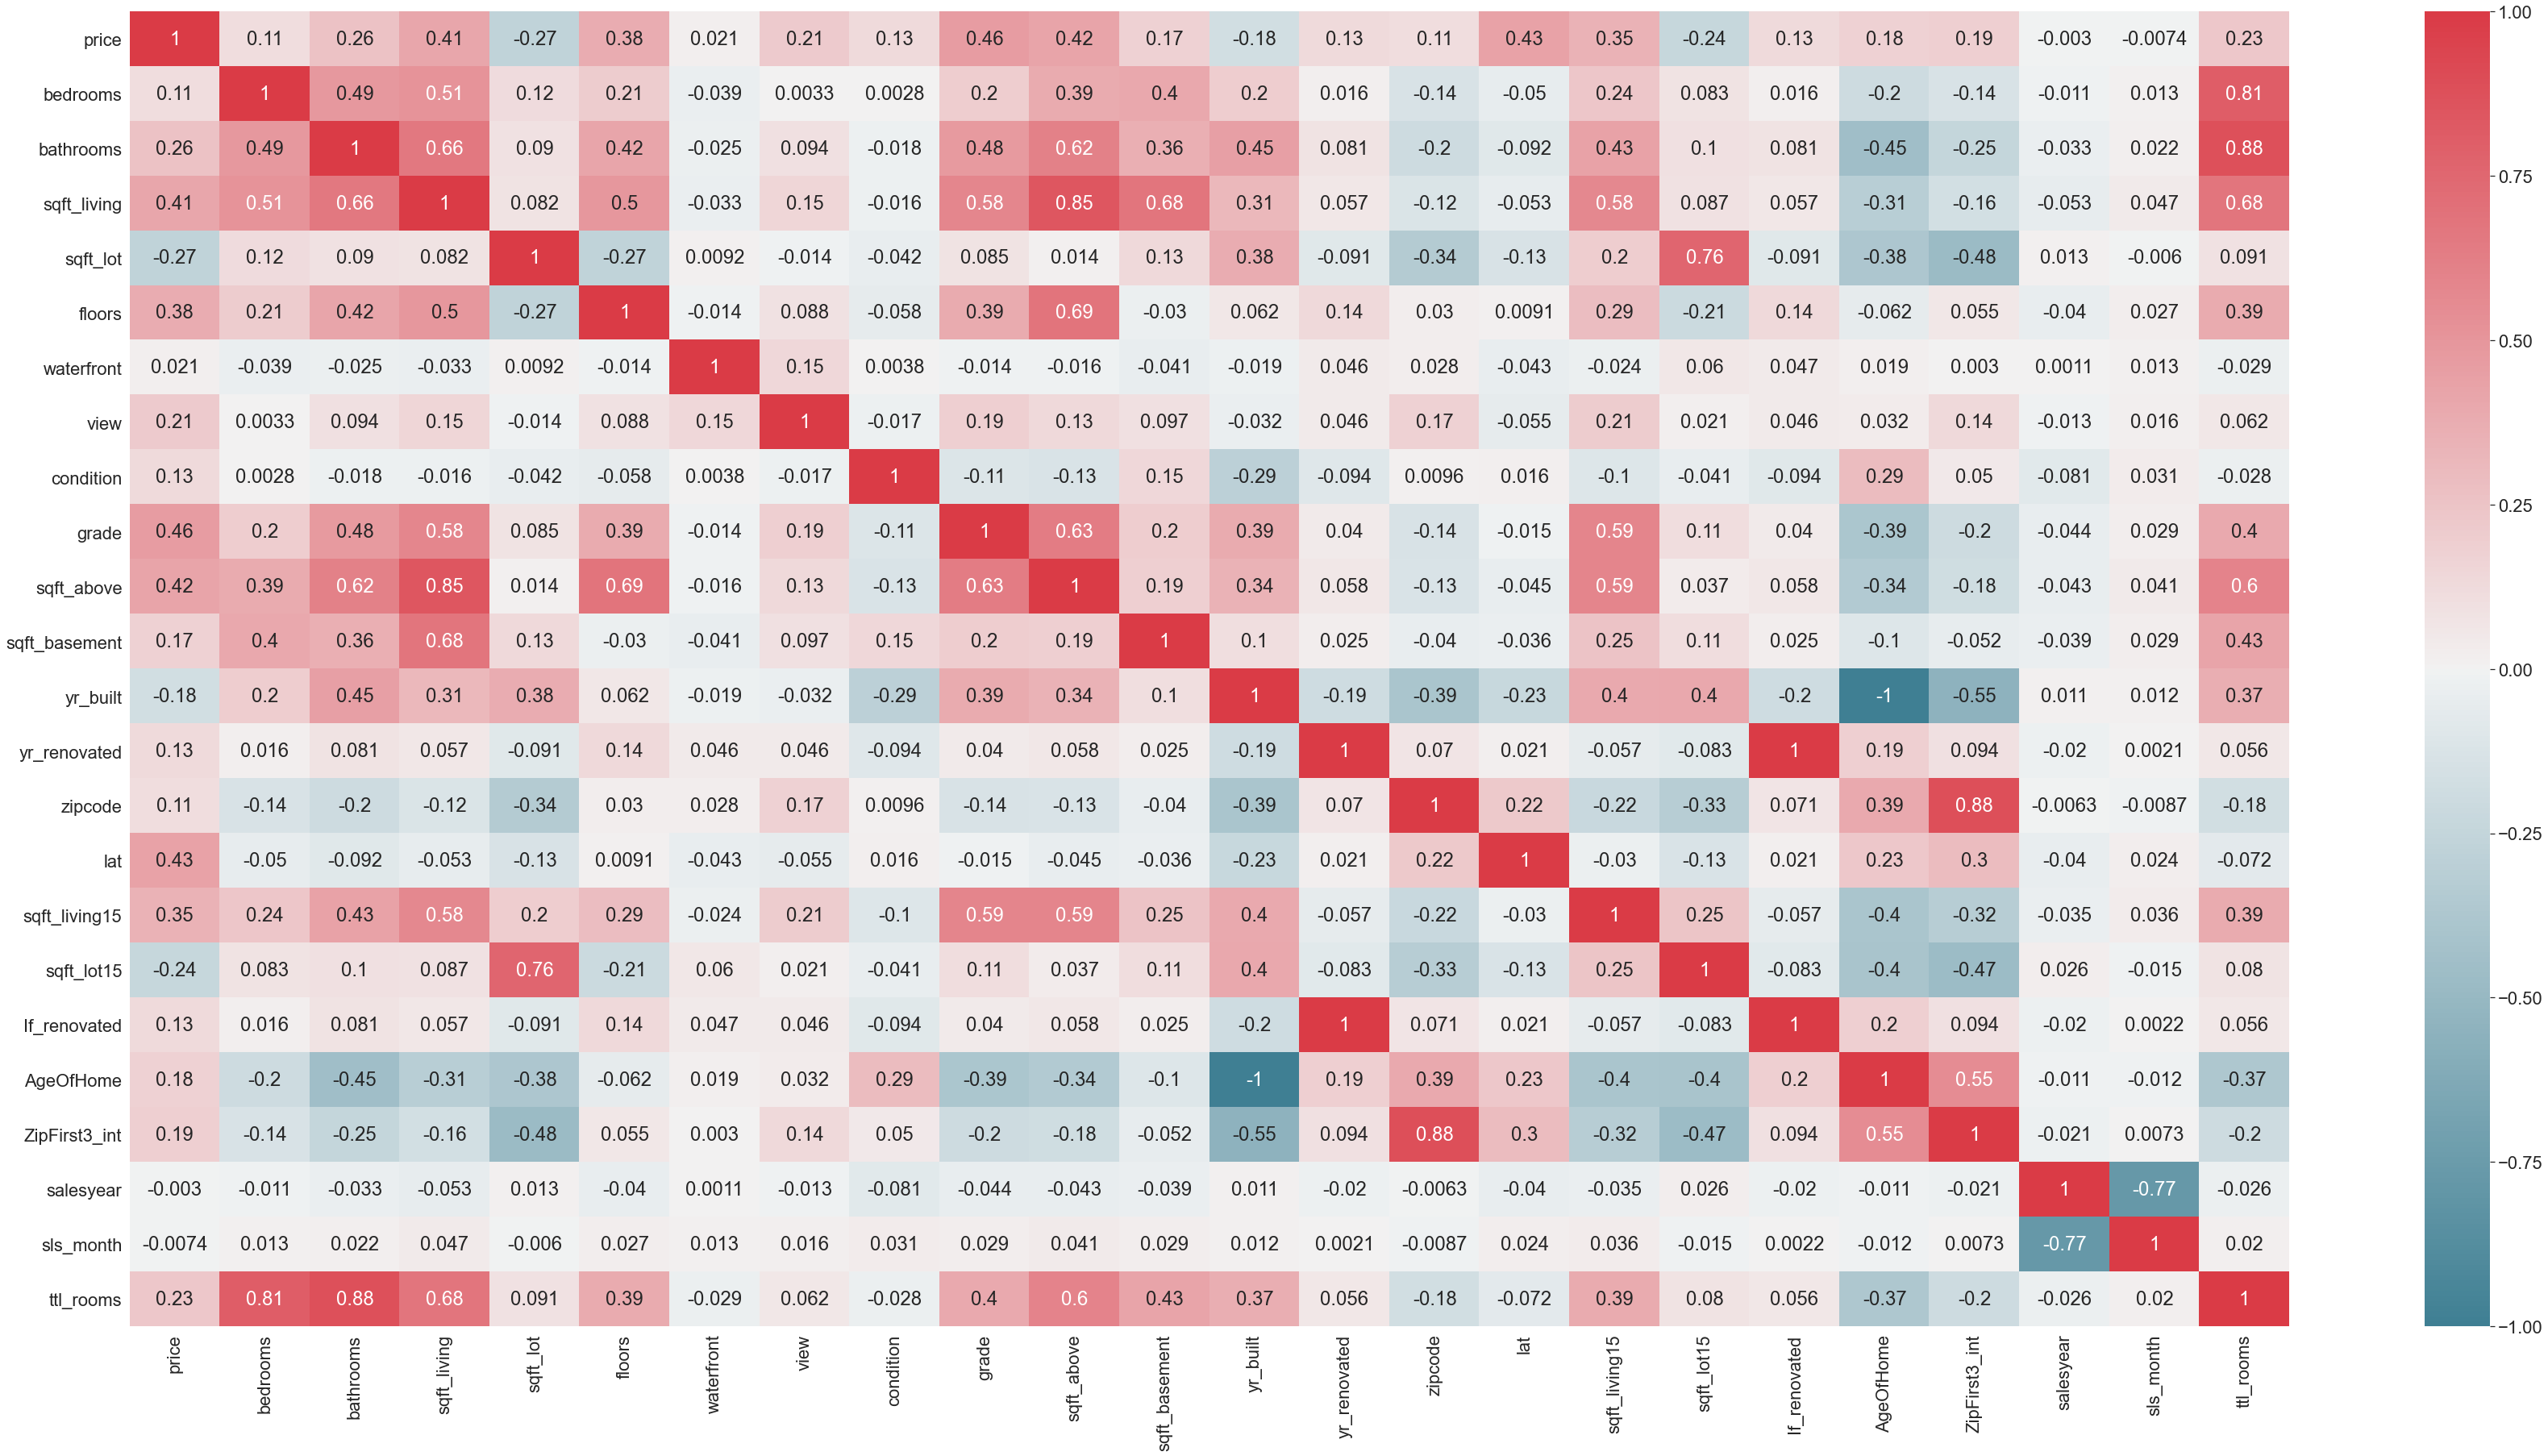

In [28]:
# Run Heat Map to ensure price has some correlation with target variables
correlation_heatmap(CheckForlinearity)

Confirming linear relationship Above

##    B. Scaling, Converting & Eliminating Multicolinearity

In [29]:
# #Exclude metadatacolumns from colinearity check as they will not feed into regression model directely

model1_Continuous_variables  = ['bedrooms', 'bathrooms','sqft_living','sqft_lot',
                                'sqft_basement','sqft_living15', 'sqft_lot15', 'floors',
                                'sqft_above','AgeOfHome','ttl_rooms']

data_Target_Homes_Continuous = data_Target_Homes[model1_Continuous_variables]

In [30]:
#Scale Continuous initial data
scaled_df_no_index, scaler_1 = scaleData_min_max (data_Target_Homes_Continuous)

Convert Categorical To Dummy

In [31]:
# categoricals = ['waterfront', 'view', 'condition', 'grade']
# dummies = pd.get_dummies(data_with_Ap_Hot_Dist_POints[categoricals], prefix=categoricals, drop_first=True)

dummies_3digitZip = pd.get_dummies(data_Target_Homes['ZipFirst3'], prefix='ZipFirst3', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('ZipFirst3', axis=1)

dummies_water = pd.get_dummies(data_Target_Homes['waterfront'], prefix='waterfront', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('waterfront', axis=1)

dummies_view = pd.get_dummies(data_Target_Homes['view'], prefix='view', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('view', axis=1)

dummies_condition = pd.get_dummies(data_Target_Homes['condition'], prefix='condition', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('condition', axis=1)

dummies_grade = pd.get_dummies(data_Target_Homes['grade'], prefix='grade', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('grade', axis=1)

dummies_salesMnth = pd.get_dummies(data_Target_Homes['sls_month'], prefix='sls_mnth' ,drop_first=True)
data_Target_Homes = data_Target_Homes.drop('sls_month', axis=1)

dummies_ifRenovated = pd.get_dummies(data_Target_Homes['If_renovated'], prefix='If_renovated' ,drop_first=True)
data_Target_Homes = data_Target_Homes.drop('If_renovated', axis=1)

data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes, dummies_water], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_3digitZip], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_view], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_condition], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_grade], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_salesMnth], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_ifRenovated], axis=1)

data_Target_Homes_Not_Scaled_WithDummies.rename(columns={'waterfront_1.0': 'waterfront_1', 'view_1.0': 'view_1',
                'view_1.0':'view_1', 'view_2.0':'view_2', 'view_3.0':'view_3', 'view_4.0':'view_4'}, inplace=True)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Not_Scaled_WithDummies.drop(['bedrooms', 'bathrooms',
                                                                                      'sqft_living',
                                                                                      'sqft_lot', 'floors', 
                                                                                      'sqft_above', 
                                                                                      'sqft_basement',
                                                                                      'sqft_living15', 
                                                                                      'sqft_lot15',
                                                                                      'AgeOfHome',
                                                                                     'ttl_rooms'],
                                                                                     axis = 1)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies.reset_index(drop=True)
data_Target_Homes_Scaled_WithDummies = pd.concat([data_Target_Homes_Scaled_WithDummies, scaled_df_no_index], axis=1)

Next Find Correlation and Mulicolinearity

In [32]:
model1_Categorical_variables = ['waterfront_1', 'view_1', 
                                'view_2', 'view_3', 'view_4', 
                                'condition_3','condition_4', 'condition_5','grade_6',
                                'grade_7','grade_8', 'grade_9', 'grade_10','grade_11', 'ZipFirst3_981',
                               "sls_mnth_2","sls_mnth_3","sls_mnth_4","sls_mnth_5","sls_mnth_6","sls_mnth_7",
                               "sls_mnth_8","sls_mnth_9", "sls_mnth_10","sls_mnth_11","sls_mnth_12","If_renovated_1"]

In [33]:
model1_Categorical_variables_to_remove = ['Na']

# model1_Categorical_variables_to_remove = ['grade_5','grade_6','condition_3', 'condition_2', 'grade_11']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['na']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

cc
pairs                               
(bathrooms, ttl_rooms)      0.877540
(sqft_living, sqft_above)   0.851069
(ttl_rooms, bedrooms)       0.811642
(condition_3, condition_4)  0.775990
(sqft_lot, sqft_lot15)      0.759141
(grade_7, grade_8)          0.756323

Remove Columns with > .70 correlation and VIF > 10

In [34]:
model1_Categorical_variables_to_remove = ['grade_7','condition_3']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['bathrooms', "bedrooms", "sqft_lot15", "sqft_living",  'floors']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


#Create Dataframefor Correlation check
colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

Empty DataFrame
Columns: [cc]
Index: []

In [35]:
vifResults = checkForVIF(data_Review_Colinearity_Model1)
vifResults

[('waterfront_1', 1.2234795165840127),
 ('view_1', 1.058851512140844),
 ('view_2', 1.1331114356460683),
 ('view_3', 1.078482103911224),
 ('view_4', 1.2414089282250547),
 ('condition_4', 1.8689660127516068),
 ('condition_5', 1.4167113336218848),
 ('grade_6', 1.1928849029797637),
 ('grade_8', 2.0137836709259602),
 ('grade_9', 1.7050182728500594),
 ('grade_10', 1.1991959937360894),
 ('grade_11', 1.0157220769393216),
 ('ZipFirst3_981', 4.462344315338232),
 ('sls_mnth_2', 1.8964159356623138),
 ('sls_mnth_3', 2.322353332674346),
 ('sls_mnth_4', 2.6316800839204397),
 ('sls_mnth_5', 2.8048025673364783),
 ('sls_mnth_6', 2.6431437141202503),
 ('sls_mnth_7', 2.495473066661459),
 ('sls_mnth_8', 2.4771777618947546),
 ('sls_mnth_9', 2.3292819240177214),
 ('sls_mnth_10', 2.4069916073408097),
 ('sls_mnth_11', 1.9870415314511167),
 ('sls_mnth_12', 2.1678986392588224),
 ('If_renovated_1', 1.16734537504166),
 ('sqft_lot', 4.933793236536014),
 ('sqft_basement', 8.256702436907018),
 ('sqft_living15', 17.20

Remove features with VIF > 10 from model 

In [36]:
model1_Categorical_variables_to_remove = ['NA']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['sqft_living15', 'AgeOfHome', 'ttl_rooms']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


#Create Dataframefor Correlation check
colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]

In [37]:
vifResults = checkForVIF(data_Review_Colinearity_Model1)
vifResults

[('waterfront_1', 1.2230283805568885),
 ('view_1', 1.0504864303912318),
 ('view_2', 1.1232012791152588),
 ('view_3', 1.0699002972707876),
 ('view_4', 1.239416028704361),
 ('condition_4', 1.6884364306542718),
 ('condition_5', 1.2966605585112048),
 ('grade_6', 1.1547969346586335),
 ('grade_8', 1.8911467203892407),
 ('grade_9', 1.5628675731577102),
 ('grade_10', 1.1613391522905012),
 ('grade_11', 1.0146245030248406),
 ('ZipFirst3_981', 3.1932146654052915),
 ('sls_mnth_2', 1.5954365560076307),
 ('sls_mnth_3', 1.880863572864325),
 ('sls_mnth_4', 2.0852193679804185),
 ('sls_mnth_5', 2.185734575337474),
 ('sls_mnth_6', 2.125033653097364),
 ('sls_mnth_7', 2.0415432906530113),
 ('sls_mnth_8', 2.013490143629826),
 ('sls_mnth_9', 1.888397736020387),
 ('sls_mnth_10', 1.9578836777744955),
 ('sls_mnth_11', 1.6405576353744946),
 ('sls_mnth_12', 1.813658409520663),
 ('If_renovated_1', 1.0761170306138148),
 ('sqft_lot', 4.606892717565416),
 ('sqft_basement', 6.501086487555035),
 ('sqft_above', 5.557610

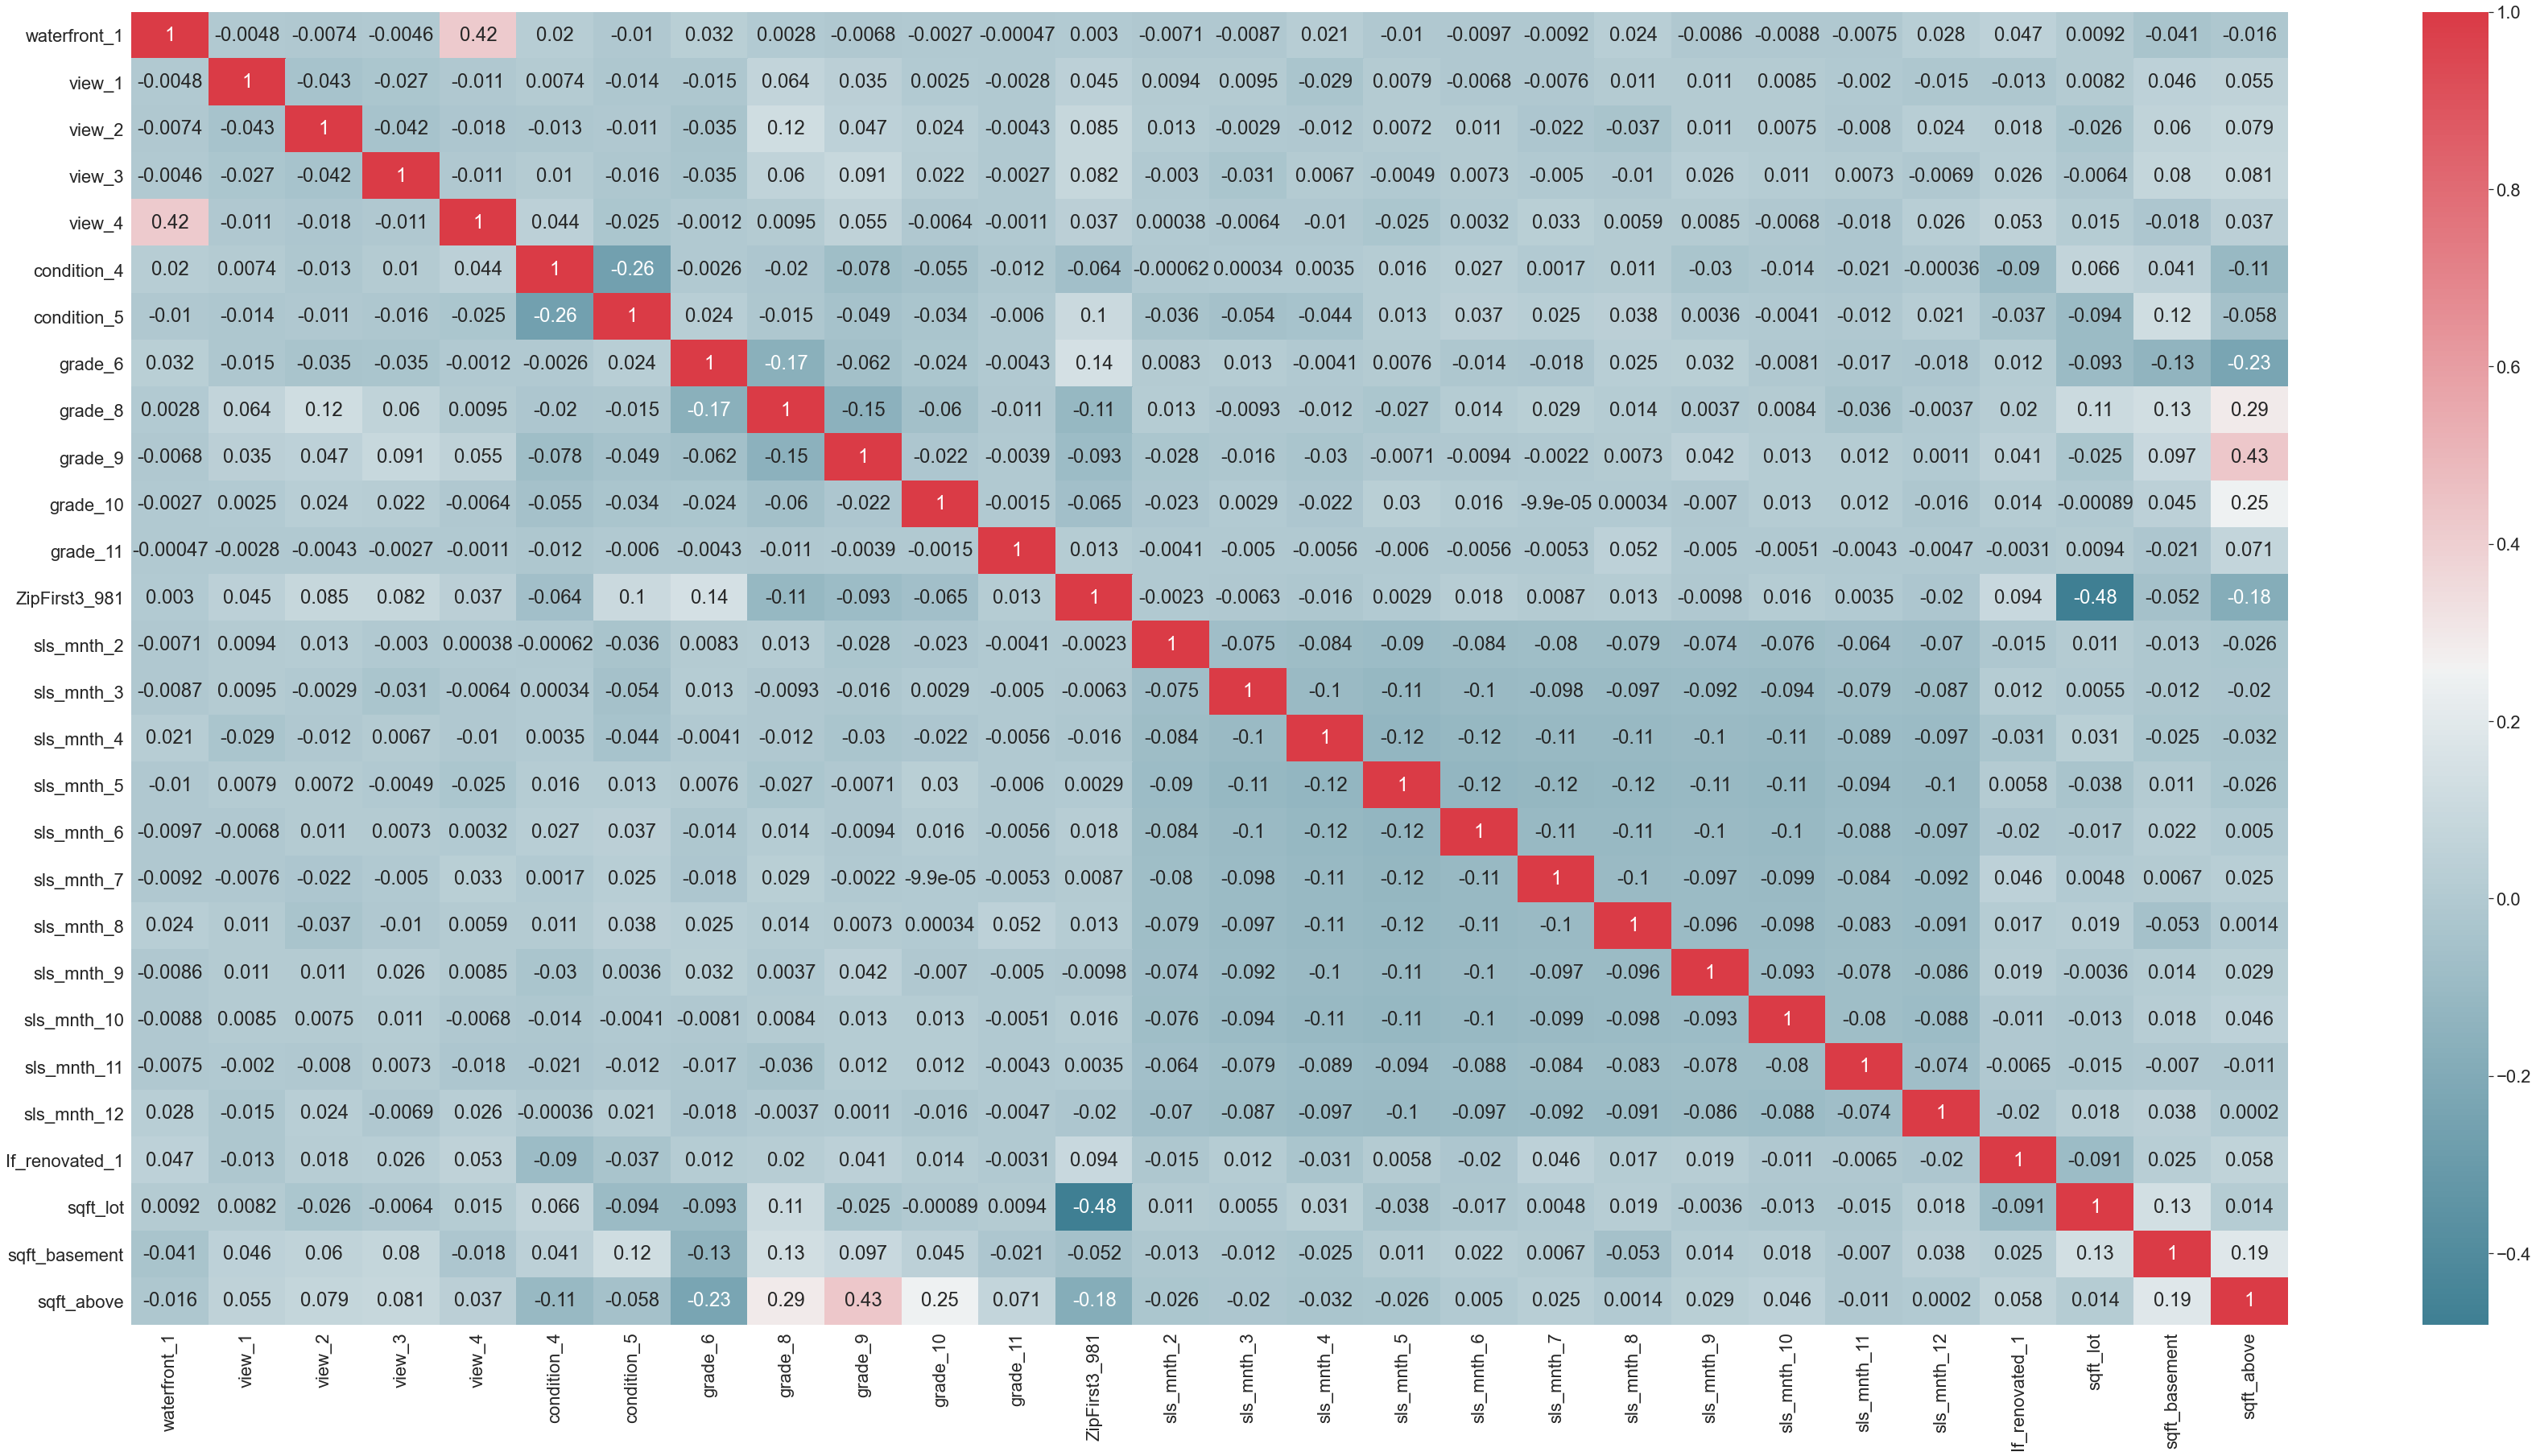

In [38]:
correlation_heatmap(data_Review_Colinearity_Model1)

##    C. Create Pickle of Dataset

Get All needed fields ready for Pickle file

In [39]:
FieldsMovingForward = ['id','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']

FieldsMovingForward.extend(data_Review_Colinearity_Model1.columns)
data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies[FieldsMovingForward]

Create Pickle File for testing Initial Model

In [40]:
with open('./data/PickleFiles/regression_Data_Initial_Model.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Scaled_WithDummies, f)
    
with open('./data/PickleFiles/regression_Data_xref.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Not_Scaled_WithDummies, f)

In [41]:
#Create Pickle of minmaxScaler
with open('./data/PickleFiles/scaler_1.pickle', 'wb') as f:
    pickle.dump(scaler_1, f)

with open('./data/PickleFiles/data_Target_Homes_Not_Scaled_WithDummies.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Not_Scaled_WithDummies, f)

with open('./data/PickleFiles/model1_Continuous_variables.pickle', 'wb') as f:
    pickle.dump(model1_Continuous_variables, f)

# <u><font color='red'>Model 2 Dataset</font></u>

##    A. Adding Features - Location Based

Add additional Location Based features - Zip HotnessScores (HotnessScore), Count of Attractions within 10 miles of home(#1,#2,#3 attractions), School district for home and its rank (SchoolDistRank)

In [42]:
# Get Data From Above - Build Upon Model 1
with open('./data/PickleFiles/regression_Data_Initial_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [43]:
#get Hotness Scores
df_Hotness_Zone = pd.read_excel("./data/ZIP_cube_HotnessZones.xlsx")
data_with_Hot = data_Model2.merge(df_Hotness_Zone[["zipcode","HotnessScore"]], on="zipcode", how="left")

#get School District & Rank
df_School_District_Info = pd.read_excel('./data/df_SchoolDistricts_SchoolDigger - all.xlsx', sheet_name='Export')
df_School_District_Ranking = pd.read_excel('./data/SchoolDisctrictRank.xlsx', sheet_name='Export')
df_School_Districts_withRank = df_School_District_Info.merge(df_School_District_Ranking, on="School District")
data_with_Hot_Dist = data_with_Hot.merge(df_School_Districts_withRank[["id","SchoolDistRankBin"]], on="id")
# data_with_Hot_Dist.rename(columns={"State Rank": "SchoolDistRank"})

#get points of interest within 7 miles
df_Points_Of_Interest = pd.read_excel('./data/df_points_of_int_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist.merge(df_Points_Of_Interest, on="id")
data_with_Hot_Dist_POints.rename(columns={1: "#1Attractions", 2: "#2Attractions", 3: "#3Attractions"}, inplace=True)

#get points of interest within 7 miles
df_Proximity_To_FortuneFives = pd.read_excel('./data/df_Counts_of_Fortune500_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.merge(df_Proximity_To_FortuneFives, on="id")


# fill in attraction columns 
data_with_Hot_Dist_POints['#1Attractions'].fillna(0, inplace=True)
data_with_Hot_Dist_POints['#2Attractions'].fillna(0, inplace=True)

data_with_Hot_Dist_POints.rename(columns={'#1Attractions':'Attractions1', '#2Attractions':'Attractions2', '#3Attractions':'Attractions3',
                                          'HotnessScore':'ZipHotnessScore'}, inplace=True)

data_with_Hot_Dist_POints.fillna(0, inplace=True)

In [44]:
#Create Pickel of data before transforming dummies, needed to create visuals for recommendation 2
with open('./data/PickleFiles/data_with_Hot_Dist_POints.pickle', 'wb') as f:
    pickle.dump(data_with_Hot_Dist_POints, f)

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [45]:
model2_Continuous_variables  = ['ZipHotnessScore','Attractions1', 'Attractions2', 'Attractions3',
                               'Over10', 'Under10', 'Over20']


model2_Categorical_variables  = ['Sch_d_Top15','Sch_d_Top30', 'Sch_d_Top60']


data_with_Hot_Dist_POints_Continuous = data_with_Hot_Dist_POints[model2_Continuous_variables]

In [46]:
#Scale Continuous initial data
scaled_df_no_index2 , scaler_2 = scaleData_min_max (data_with_Hot_Dist_POints_Continuous)

In [47]:
#create dummies for new categorical
dummies_SchoolRankBins = pd.get_dummies(data_with_Hot_Dist_POints['SchoolDistRankBin'], prefix='Sch_d', drop_first=True)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.drop('SchoolDistRankBin', axis=1)

#Add dummies back to main DF
data_with_Hot_Dist_POints_WithDummies = pd.concat([data_with_Hot_Dist_POints, dummies_SchoolRankBins], axis=1)

#drop original features that got scaled above
data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.drop(model2_Continuous_variables, axis=1)

data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.reset_index(drop=True)

#bring newly scaled and dummies together
data_with_Hot_Dist_POints = pd.concat([data_with_Hot_Dist_POints_WithDummies, scaled_df_no_index2], axis=1)

In [48]:
data_with_Hot_Dist_POints_Continuous.columns

Index(['ZipHotnessScore', 'Attractions1', 'Attractions2', 'Attractions3',
       'Over10', 'Under10', 'Over20'],
      dtype='object')

In [49]:
data_with_Hot_Dist_POints.head()

id       date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  waterfront_1  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  grade_11  ZipFirst3_981  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  sqft_lot  sqft_basement  sqft_above  Over7  Under7  Sch_d_Top15  Sch_d_Top30  Sch_d_Top60  ZipHotnessScore  Attractions1  Attractions2  Attractions3  Over10   Under10  Over20
0  6414100192  12/9/2014  538000.0      1951        1991.0    98125  47.7210 -122.319  13.195614             0       0       0       0       0            0            0        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               1  0.540333       0.184332    0.493289     10       1            0            1            0         0.783658      0.340961      0.258993      0.281948   0.250  0.428571    0.05
1  2487200875  12/9/2014  604000.0      1965           0.0    98136  47.5208 -122.393  13.311329             0       0       0       0       0            0            1        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               0  0.166667       0.419355    0.117450      8       3            0            1            0         0.833038      0.306636      0.431655      0.260546   0.250  0.428571    0.05
2  1736800520   4/3/2015  662500.0      1965           0.0    98007  47.6007 -122.145  13.403776             0       0       0       0       0            0            0        0        1        0         0         0              0           0           0           1           0           0           0           0           0            0            0            0               0  0.966000       0.783410    0.389262      7       4            1            0            0         0.813773      0.290618      0.273381      0.214020   0.125  0.571429    0.05
3  9212900260  5/27/2014  468000.0      1942           0.0    98115  47.6900 -122.292  13.056224             0       0       0       0       0            1            0        0        0        0         0         0              1           0           0           0           1           0           0           0           0            0            0            0               0  0.333333       0.138249    0.053691      6       5            0            1            0         0.888840      0.489703      0.453237      0.473325   0.250  0.500000    0.00
4  9297300055  1/24/2015  650000.0      1979           0.0    98126  47.5714 -122.375  13.384728             0       0       0       1       0            0            0        0        0        1         0         0              1           0           0           0           0           0           0           0           0            0            0            0               0  0.166667       0.447005    0.429530      7       4            0            1            0         0.763508      0.405034      0.424460      0.403846   0.250  0.428571    0.05

Check For Colinearity - feed all relevant categorical and dummy variables into colinearity review

In [50]:
model1_Categorical_variables_to_remove = ['waterfront_1']
# model2_Categorical_variables = model1_Categorical_variables
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model2_Categorical_variables_to_remove = ['NA']
# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['NA']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

cc
pairs                                     
(Attractions1, Attractions3)      0.949875
(Attractions3, Attractions2)      0.934396
(Attractions2, Attractions1)      0.926765
(Under10, Attractions1)           0.847408
(Sch_d_Top30, Attractions3)       0.813038
(ZipHotnessScore, ZipFirst3_981)  0.792632
(Under10, Attractions2)           0.786853
(ZipFirst3_981, Sch_d_Top30)      0.774070
(Under10, Attractions3)           0.769250
(Sch_d_Top30, Attractions2)       0.743191

In [51]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

[('Sch_d_Top15', 3.1401738283929013),
 ('Sch_d_Top30', 12.40460948783235),
 ('Sch_d_Top60', 1.6492164582846263),
 ('ZipHotnessScore', 49.55637149501352),
 ('Attractions1', 229.7557695311593),
 ('Attractions2', 70.1344261330726),
 ('Attractions3', 151.07292461491423),
 ('Over10', 18.810497527664253),
 ('Under10', 56.219158848495546),
 ('Over20', 3.6163545515125413),
 ('sqft_lot', 7.013185778225938),
 ('sqft_basement', 6.894220682360459),
 ('sqft_above', 6.0245766136703605),
 ('view_1', 1.0612311224220385),
 ('view_2', 1.1322720325792814),
 ('view_3', 1.085923531457697),
 ('view_4', 1.02902675722432),
 ('condition_4', 1.7436446431157835),
 ('condition_5', 1.309732853032865),
 ('grade_6', 1.1880783667445627),
 ('grade_8', 1.9367430094586384),
 ('grade_9', 1.5927673237136466),
 ('grade_10', 1.1693491113414092),
 ('grade_11', 1.0176491778363004),
 ('ZipFirst3_981', 14.188730893856919),
 ('sls_mnth_2', 2.440162750526947),
 ('sls_mnth_3', 3.0545625598251753),
 ('sls_mnth_4', 3.532781806904248

Drop variables that violate correlation and VIF 

In [52]:
model1_Categorical_variables_to_remove = ['ZipFirst3_981','grade_11']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['AgeOfHome']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables_to_remove = ['NA']
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['Attractions2','Attractions3', 'Attractions1','ZipHotnessScore','Over10']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

Empty DataFrame
Columns: [cc]
Index: []

In [53]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

[('Sch_d_Top15', 2.57961030959551),
 ('Sch_d_Top30', 5.418709562569284),
 ('Sch_d_Top60', 1.3400238565336726),
 ('Under10', 9.637096242447363),
 ('Over20', 2.3119789300225086),
 ('sqft_lot', 5.784805165188254),
 ('sqft_basement', 6.656715444553458),
 ('sqft_above', 5.722588620467307),
 ('view_1', 1.0503938090471383),
 ('view_2', 1.1191159375532398),
 ('view_3', 1.0704642637126727),
 ('view_4', 1.0215435967366213),
 ('condition_4', 1.7021285953552616),
 ('condition_5', 1.3044027417199768),
 ('grade_6', 1.157364661559057),
 ('grade_8', 1.8866817832900196),
 ('grade_9', 1.5546973767207677),
 ('grade_10', 1.1560233081262252),
 ('sls_mnth_2', 1.8799588577077138),
 ('sls_mnth_3', 2.2391430982695453),
 ('sls_mnth_4', 2.5784272415557092),
 ('sls_mnth_5', 2.7703717418776455),
 ('sls_mnth_6', 2.600120336891271),
 ('sls_mnth_7', 2.445908558826426),
 ('sls_mnth_8', 2.410403635207033),
 ('sls_mnth_9', 2.305075766060203),
 ('sls_mnth_10', 2.3744483362860045),
 ('sls_mnth_11', 1.9628217733404054),
 (

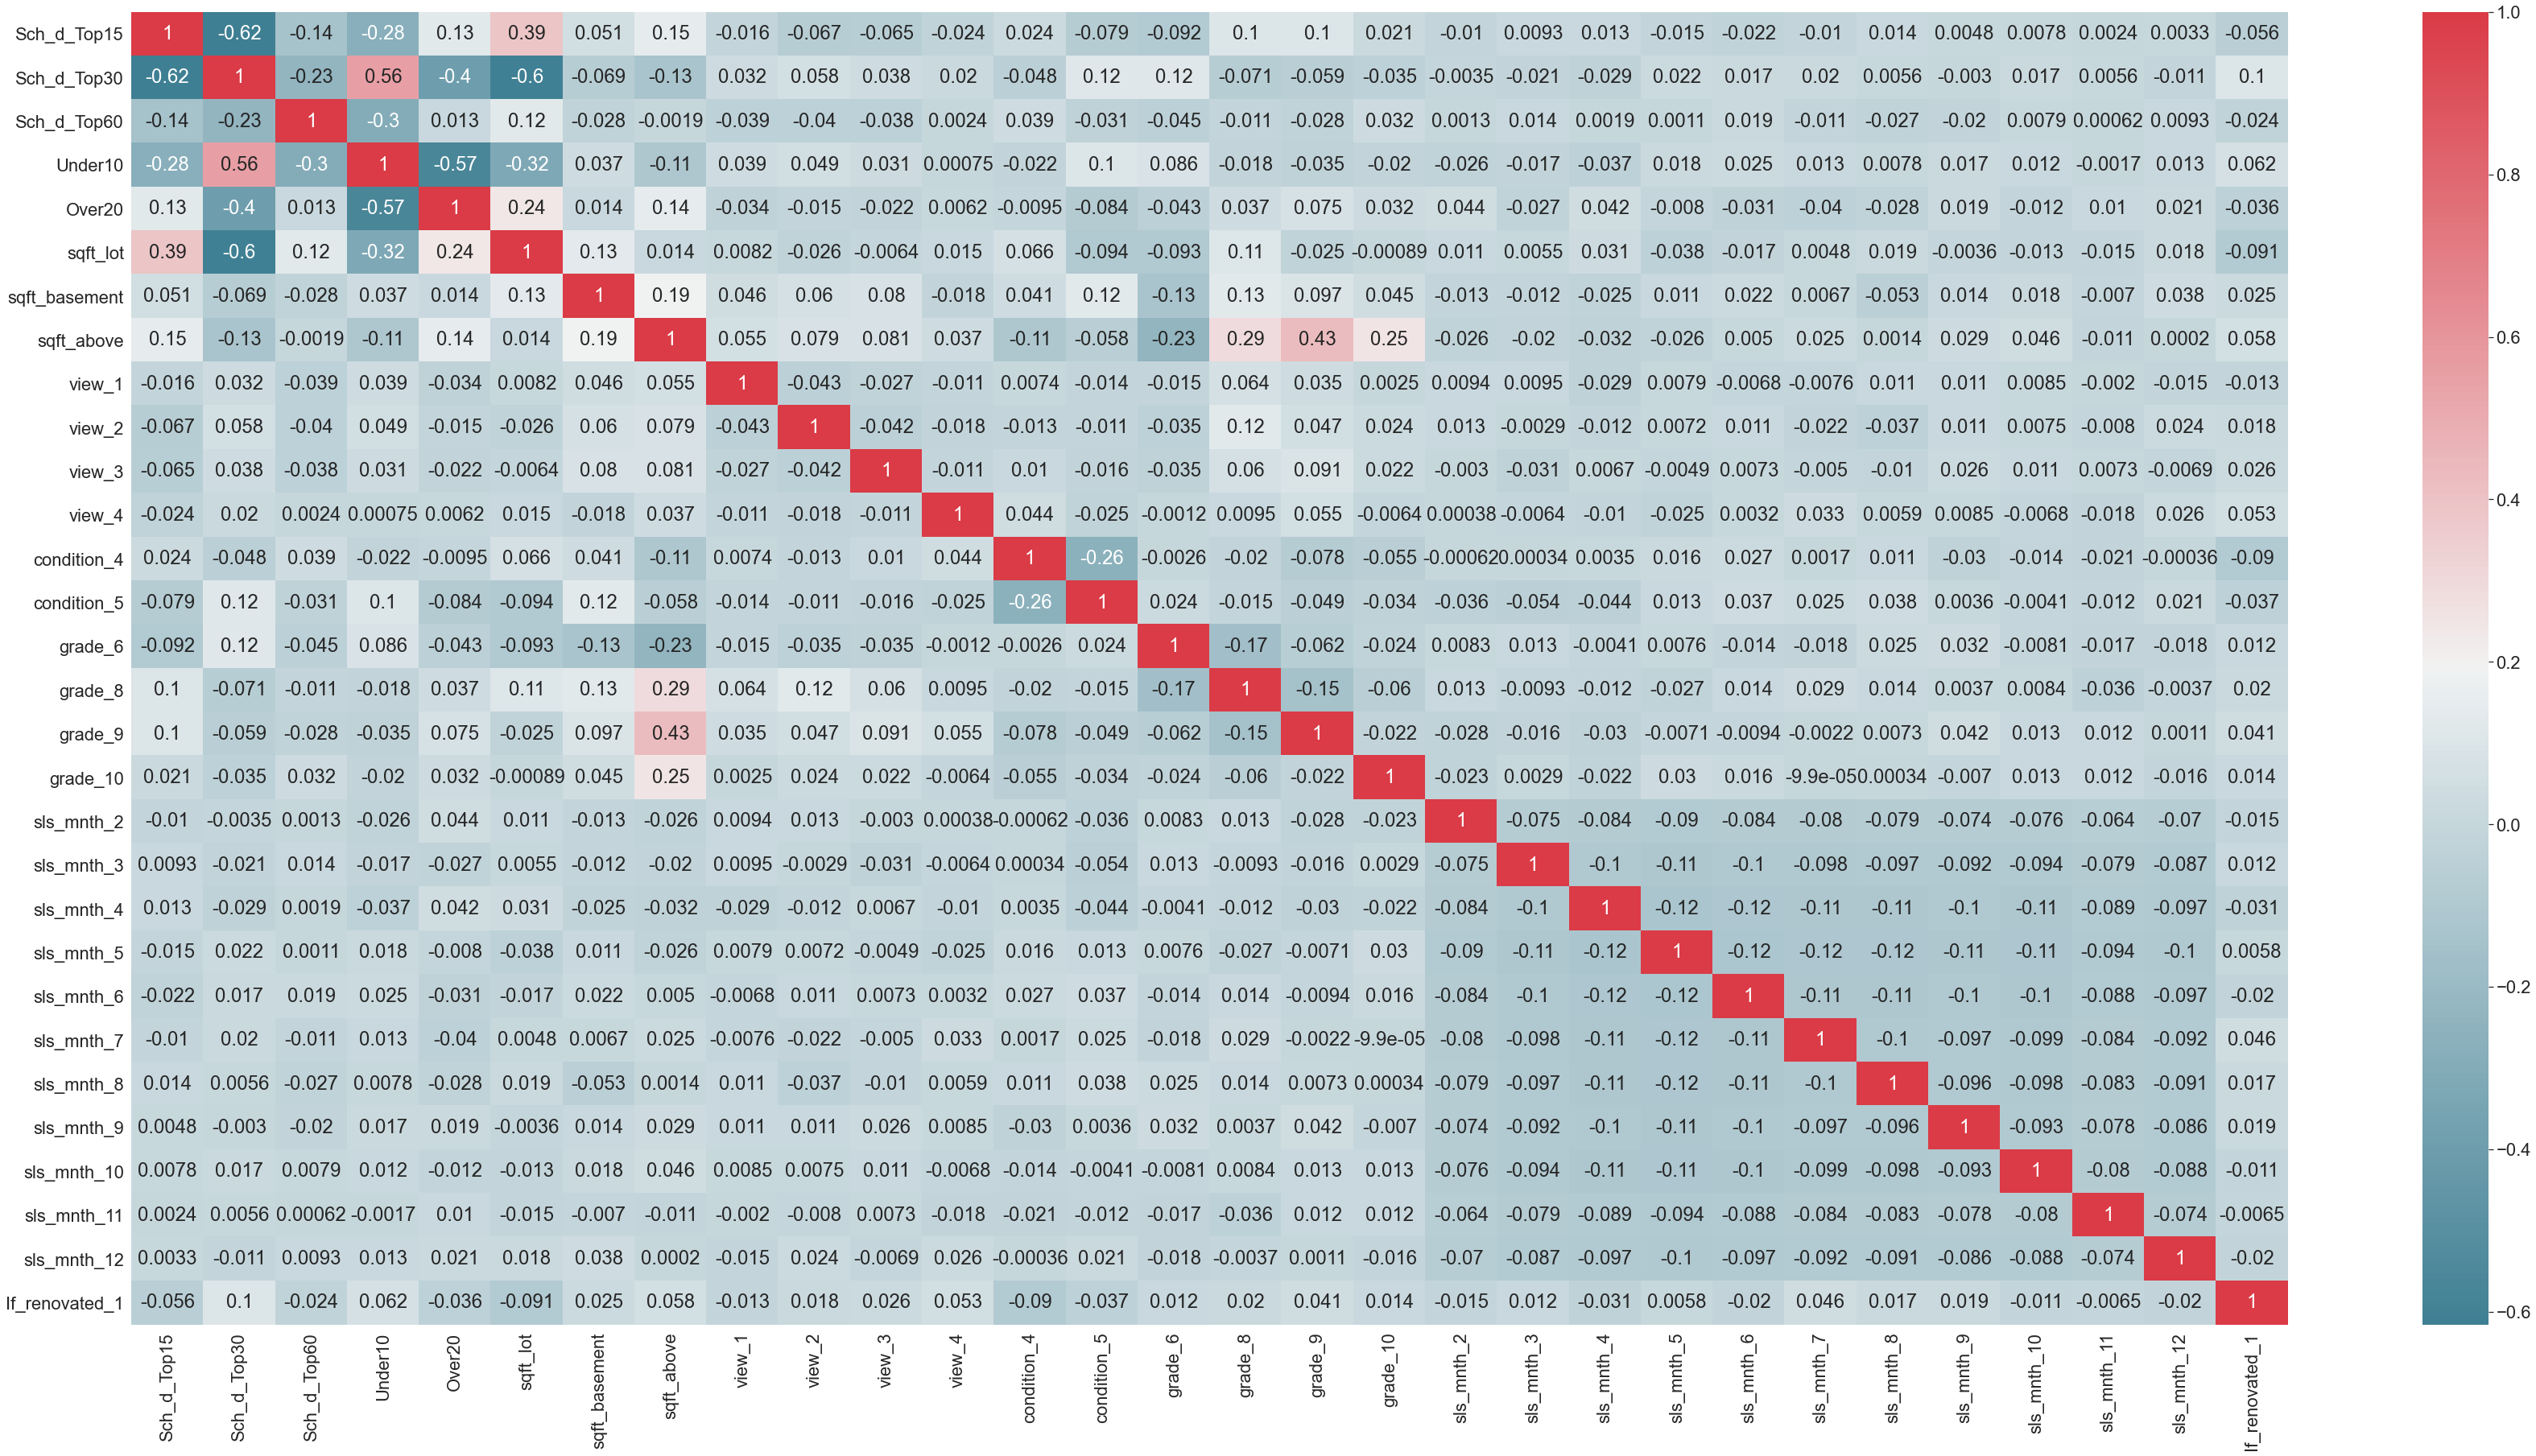

In [54]:
correlation_heatmap(data_Review_Colinearity_Model2)

##     C. Create Pickle of Dataset

In [55]:
FieldsMovingForward = ['id','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']
FieldsMovingForward.extend(data_Review_Colinearity_Model2.columns)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints[FieldsMovingForward]

In [56]:
with open('./data/PickleFiles/regression_Data_Second_Model.pickle', 'wb') as f:
    pickle.dump(data_with_Hot_Dist_POints, f)

In [57]:
#Create Pickle of minmaxScaler
with open('./data/PickleFiles/scaler_2.pickle', 'wb') as f:
    pickle.dump(scaler_2, f)

with open('./data/PickleFiles/data_with_Hot_Dist_POints_WithDummies.pickle', 'wb') as f:
    pickle.dump(data_with_Hot_Dist_POints_WithDummies, f)


# <u> <font color='red'>Model 3 Dataset</font> </u>

## A. Adding Features - Previous Year Assesor Values

Add additional previous yr county assessor valuation - AppraisedLandValue, AppraisedImpsValue(aka house value), LandToHouseCheck, InflationSinceLastAppraisal

In [58]:
# Get Data From Above - Build Upon Model 2

# Load Data From Pickel
with open('./data/PickleFiles/regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

In [59]:
data_Model3['salesyear'] = pd.DatetimeIndex(data_Model3['date']).year
data_Model3['yearpriortosale'] = data_Model3['salesyear'] - 1
data_Model3["yearpriortosale_str"] = data_Model3["yearpriortosale"].astype('str')
data_Model3["id_str"] = data_Model3["id"].astype('str')
data_Model3['appraisalKey'] = data_Model3['id_str'] + data_Model3['yearpriortosale_str']

#get Appraisal Data - inner join to eleminate valus with no appraisals
df_Appraisal_Info = pd.read_excel('./data/Appraisals_Values_Table_w_3yrRolling.xlsx')
df_Appraisal_Info["appraisalKey"] = df_Appraisal_Info["appraisalKey"].astype('str')

df_Appraisal_Info["AssesorAppraisals_x"] = df_Appraisal_Info['Taxable Land Value']*df_Appraisal_Info['Taxable Imps Value']
df_Appraisal_Info = df_Appraisal_Info[df_Appraisal_Info["AssesorAppraisals_x"]>0]

df_data_with_Appraisals = data_Model3.merge(df_Appraisal_Info[['YrRollingAppraisal','AppraisedLandValue','AppraisedImpsValue','AppraisedTotal','LandToHouseCheck','InflationSinceLastAppraisal','InflationSinceLastAppraisal_abs','AssesorAppraisals_x','Taxable Total','appraisalKey']], on="appraisalKey", how="inner")

df_data_with_Appraisals.drop(['appraisalKey', 'id_str', 'salesyear', 'yearpriortosale_str', 'yearpriortosale'], axis=1, inplace=True)

In [60]:
#Remove addtiaional outliers, "abnarmally" expensive, big, etc. homes 

df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['LandToHouseCheck'] <= .65]
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['InflationSinceLastAppraisal_abs'] <= .10]
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['AppraisedTotal'] <= 850000]

# df_data_with_Appraisals = df_data_with_Appraisals.loc[(250000 <= df_data_with_Appraisals['AppraisedTotal']) & (df_data_with_Appraisals['AppraisedTotal'] <= 850000)]


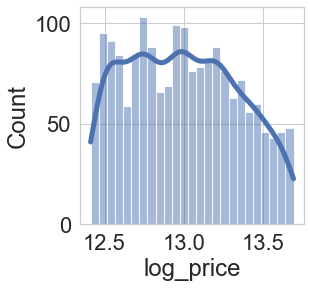

In [61]:
#Review distribution of Target/ dependent after additional removals of outliers
fig = plt.figure(figsize = (4,4))
ax = fig.gca()
sns.histplot(x= "log_price",
             data=df_data_with_Appraisals,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [62]:
model3_Continuous_variables  = ['YrRollingAppraisal','AppraisedLandValue', 
                                  'AppraisedImpsValue', 'LandToHouseCheck',
                                  'InflationSinceLastAppraisal', 
                                  'InflationSinceLastAppraisal_abs', 'AppraisedTotal', 'AssesorAppraisals_x']


data_with_Appraisals_Continuous = df_data_with_Appraisals[model3_Continuous_variables]

In [63]:
# Scale new continuous variables
scaled_df_no_index3, scaler_3 = scaleData_min_max (data_with_Appraisals_Continuous)

In [64]:
df_data_with_Appraisals_Not_Scaled = df_data_with_Appraisals.drop(model3_Continuous_variables, axis=1)
df_data_with_Appraisals_Not_Scaled = df_data_with_Appraisals_Not_Scaled.reset_index(drop=True)
df_data_with_Appraisals = pd.concat([df_data_with_Appraisals_Not_Scaled, scaled_df_no_index3], axis=1)

In [65]:
df_data_with_Appraisals.head()

id       date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  Sch_d_Top15  Sch_d_Top30  Sch_d_Top60   Under10  Over20  sqft_lot  sqft_basement  sqft_above  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  Taxable Total  YrRollingAppraisal  AppraisedLandValue  AppraisedImpsValue  LandToHouseCheck  InflationSinceLastAppraisal  InflationSinceLastAppraisal_abs  AppraisedTotal  AssesorAppraisals_x
0  2487200875  12/9/2014  604000.0      1965           0.0    98136  47.5208 -122.393  13.311329            0            1            0  0.428571    0.05  0.166667       0.419355    0.117450       0       0       0       0            0            1        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               0         351000            0.422462            0.276284            0.264348          0.601194                     0.932886                         0.866873        0.325137             0.162674
1  9212900260  5/27/2014  468000.0      1942           0.0    98115  47.6900 -122.292  13.056224            0            1            0  0.500000    0.00  0.333333       0.138249    0.053691       0       0       0       0            1            0        0        0        0         0           0           0           0           1           0           0           0           0            0            0            0               0         399000            0.468251            0.484108            0.200000          0.920210                     0.920544                         0.842391        0.390710             0.205829
2  9297300055  1/24/2015  650000.0      1979           0.0    98126  47.5714 -122.375  13.384728            0            1            0  0.428571    0.05  0.166667       0.447005    0.429530       0       0       1       0            0            0        0        0        1         0           0           0           0           0           0           0           0           0            0            0            0               0         759000            0.819870            0.667482            0.695652          0.538607                     0.990773                         0.981697        0.882514             0.801466
3  7955080270  12/3/2014  322500.0      1981           0.0    98058  47.4276 -122.157  12.683858            0            0            1  0.214286    0.05  0.443167       0.359447    0.194631       0       0       0       0            0            0        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               0         225000            0.269115            0.237164            0.073043          0.964562                     0.563994                         0.135135        0.153005             0.053780
4  1432701230  7/29/2014  309000.0      1959           0.0    98058  47.4485 -122.175  12.641097            0            0            0  0.214286    0.05  0.942667       0.165899    0.073826       0       0       0       0            1            0        1        0        0         0           0           0           0           0           0           1           0           0            0            0            0               0         176000            0.203024            0.048900            0.121739          0.438906                     1.000000                         1.000000        0.086066             0.027173

Check For Colinearity

In [66]:
model1_Categorical_variables

['view_1',
 'view_2',
 'view_3',
 'view_4',
 'condition_4',
 'condition_5',
 'grade_6',
 'grade_8',
 'grade_9',
 'grade_10',
 'sls_mnth_2',
 'sls_mnth_3',
 'sls_mnth_4',
 'sls_mnth_5',
 'sls_mnth_6',
 'sls_mnth_7',
 'sls_mnth_8',
 'sls_mnth_9',
 'sls_mnth_10',
 'sls_mnth_11',
 'sls_mnth_12',
 'If_renovated_1']

In [67]:
model3_Continuous_variables_to_remove = ['NA']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

cc
pairs                                                                   
(AssesorAppraisals_x, AppraisedTotal)                           0.976462
(YrRollingAppraisal, AppraisedTotal)                            0.962037
(YrRollingAppraisal, AssesorAppraisals_x)                       0.943970
(AppraisedImpsValue, AppraisedTotal)                            0.890839
(AppraisedImpsValue, AssesorAppraisals_x)                       0.855704
(AppraisedLandValue, AppraisedTotal)                            0.845262
(AssesorAppraisals_x, AppraisedLandValue)                       0.842029
(YrRollingAppraisal, AppraisedImpsValue)                        0.839890
(AppraisedLandValue, YrRollingAppraisal)                        0.833322
(InflationSinceLastAppraisal_abs, InflationSinceLastAppraisal)  0.726800

In [68]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

[('YrRollingAppraisal', 27.229416656135104),
 ('AppraisedLandValue', 5030.063099935431),
 ('AppraisedImpsValue', 6652.199210051755),
 ('LandToHouseCheck', 10.211087354212244),
 ('InflationSinceLastAppraisal', 2.4530654026931002),
 ('InflationSinceLastAppraisal_abs', 2.2864266291233455),
 ('AppraisedTotal', 18260.112204627174),
 ('AssesorAppraisals_x', 27.327135500738446),
 ('Sch_d_Top15', 2.211492960487343),
 ('Sch_d_Top30', 4.190408723860007),
 ('Sch_d_Top60', 1.3982899706310008),
 ('Under10', 2.905211140175194),
 ('Over20', 2.07468079821961),
 ('sqft_lot', 1.8306114242742575),
 ('sqft_basement', 1.198744897535998),
 ('sqft_above', 2.9029477924363496),
 ('view_1', 1.048988322565638),
 ('view_2', 1.1053225690639499),
 ('view_3', 1.113206801428315),
 ('view_4', 1.0739703352931709),
 ('condition_4', 1.2116776490843135),
 ('condition_5', 1.1670607621351163),
 ('grade_6', 1.153036751628845),
 ('grade_8', 1.5958326368603342),
 ('grade_9', 1.8153261217936587),
 ('grade_10', 1.1842274375571),

In [69]:
model1_Categorical_variables_to_remove = ['waterfront_1']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove_v1 = ['NA']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove_v1)]

model3_Continuous_variables_to_remove = ['YrRollingAppraisal','InflationSinceLastAppraisal_abs','LandToHouseCheck',
                                         'InflationSinceLastAppraisal','AppraisedImpsValue','AppraisedLandValue','AppraisedTotal']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Categorical_variables + model1_Continuous_variables 

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

Empty DataFrame
Columns: [cc]
Index: []

In [70]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

[('AssesorAppraisals_x', 6.294572609227828),
 ('Sch_d_Top15', 2.112412803691003),
 ('Sch_d_Top30', 6.088975315110999),
 ('Sch_d_Top60', 1.323321940786265),
 ('Under10', 9.65497974074645),
 ('Over20', 2.6388553902575516),
 ('view_1', 1.0655934450914184),
 ('view_2', 1.1432310794375111),
 ('view_3', 1.1169678076635405),
 ('view_4', 1.0532697636854895),
 ('condition_4', 1.7437128456099054),
 ('condition_5', 1.299951650244402),
 ('grade_6', 1.1425260224617027),
 ('grade_8', 2.0459156800431484),
 ('grade_9', 1.7959183061110382),
 ('grade_10', 1.1532213568121092),
 ('sls_mnth_2', 1.8571229568551415),
 ('sls_mnth_3', 2.1558948558598328),
 ('sls_mnth_4', 2.588756636250859),
 ('sls_mnth_5', 2.6372334086001312),
 ('sls_mnth_6', 2.5346950229136787),
 ('sls_mnth_7', 2.3816060532214434),
 ('sls_mnth_8', 2.2859179136262293),
 ('sls_mnth_9', 2.2343117121623006),
 ('sls_mnth_10', 2.45356435816948),
 ('sls_mnth_11', 2.070367030755835),
 ('sls_mnth_12', 2.1219266487762956),
 ('If_renovated_1', 1.0788065

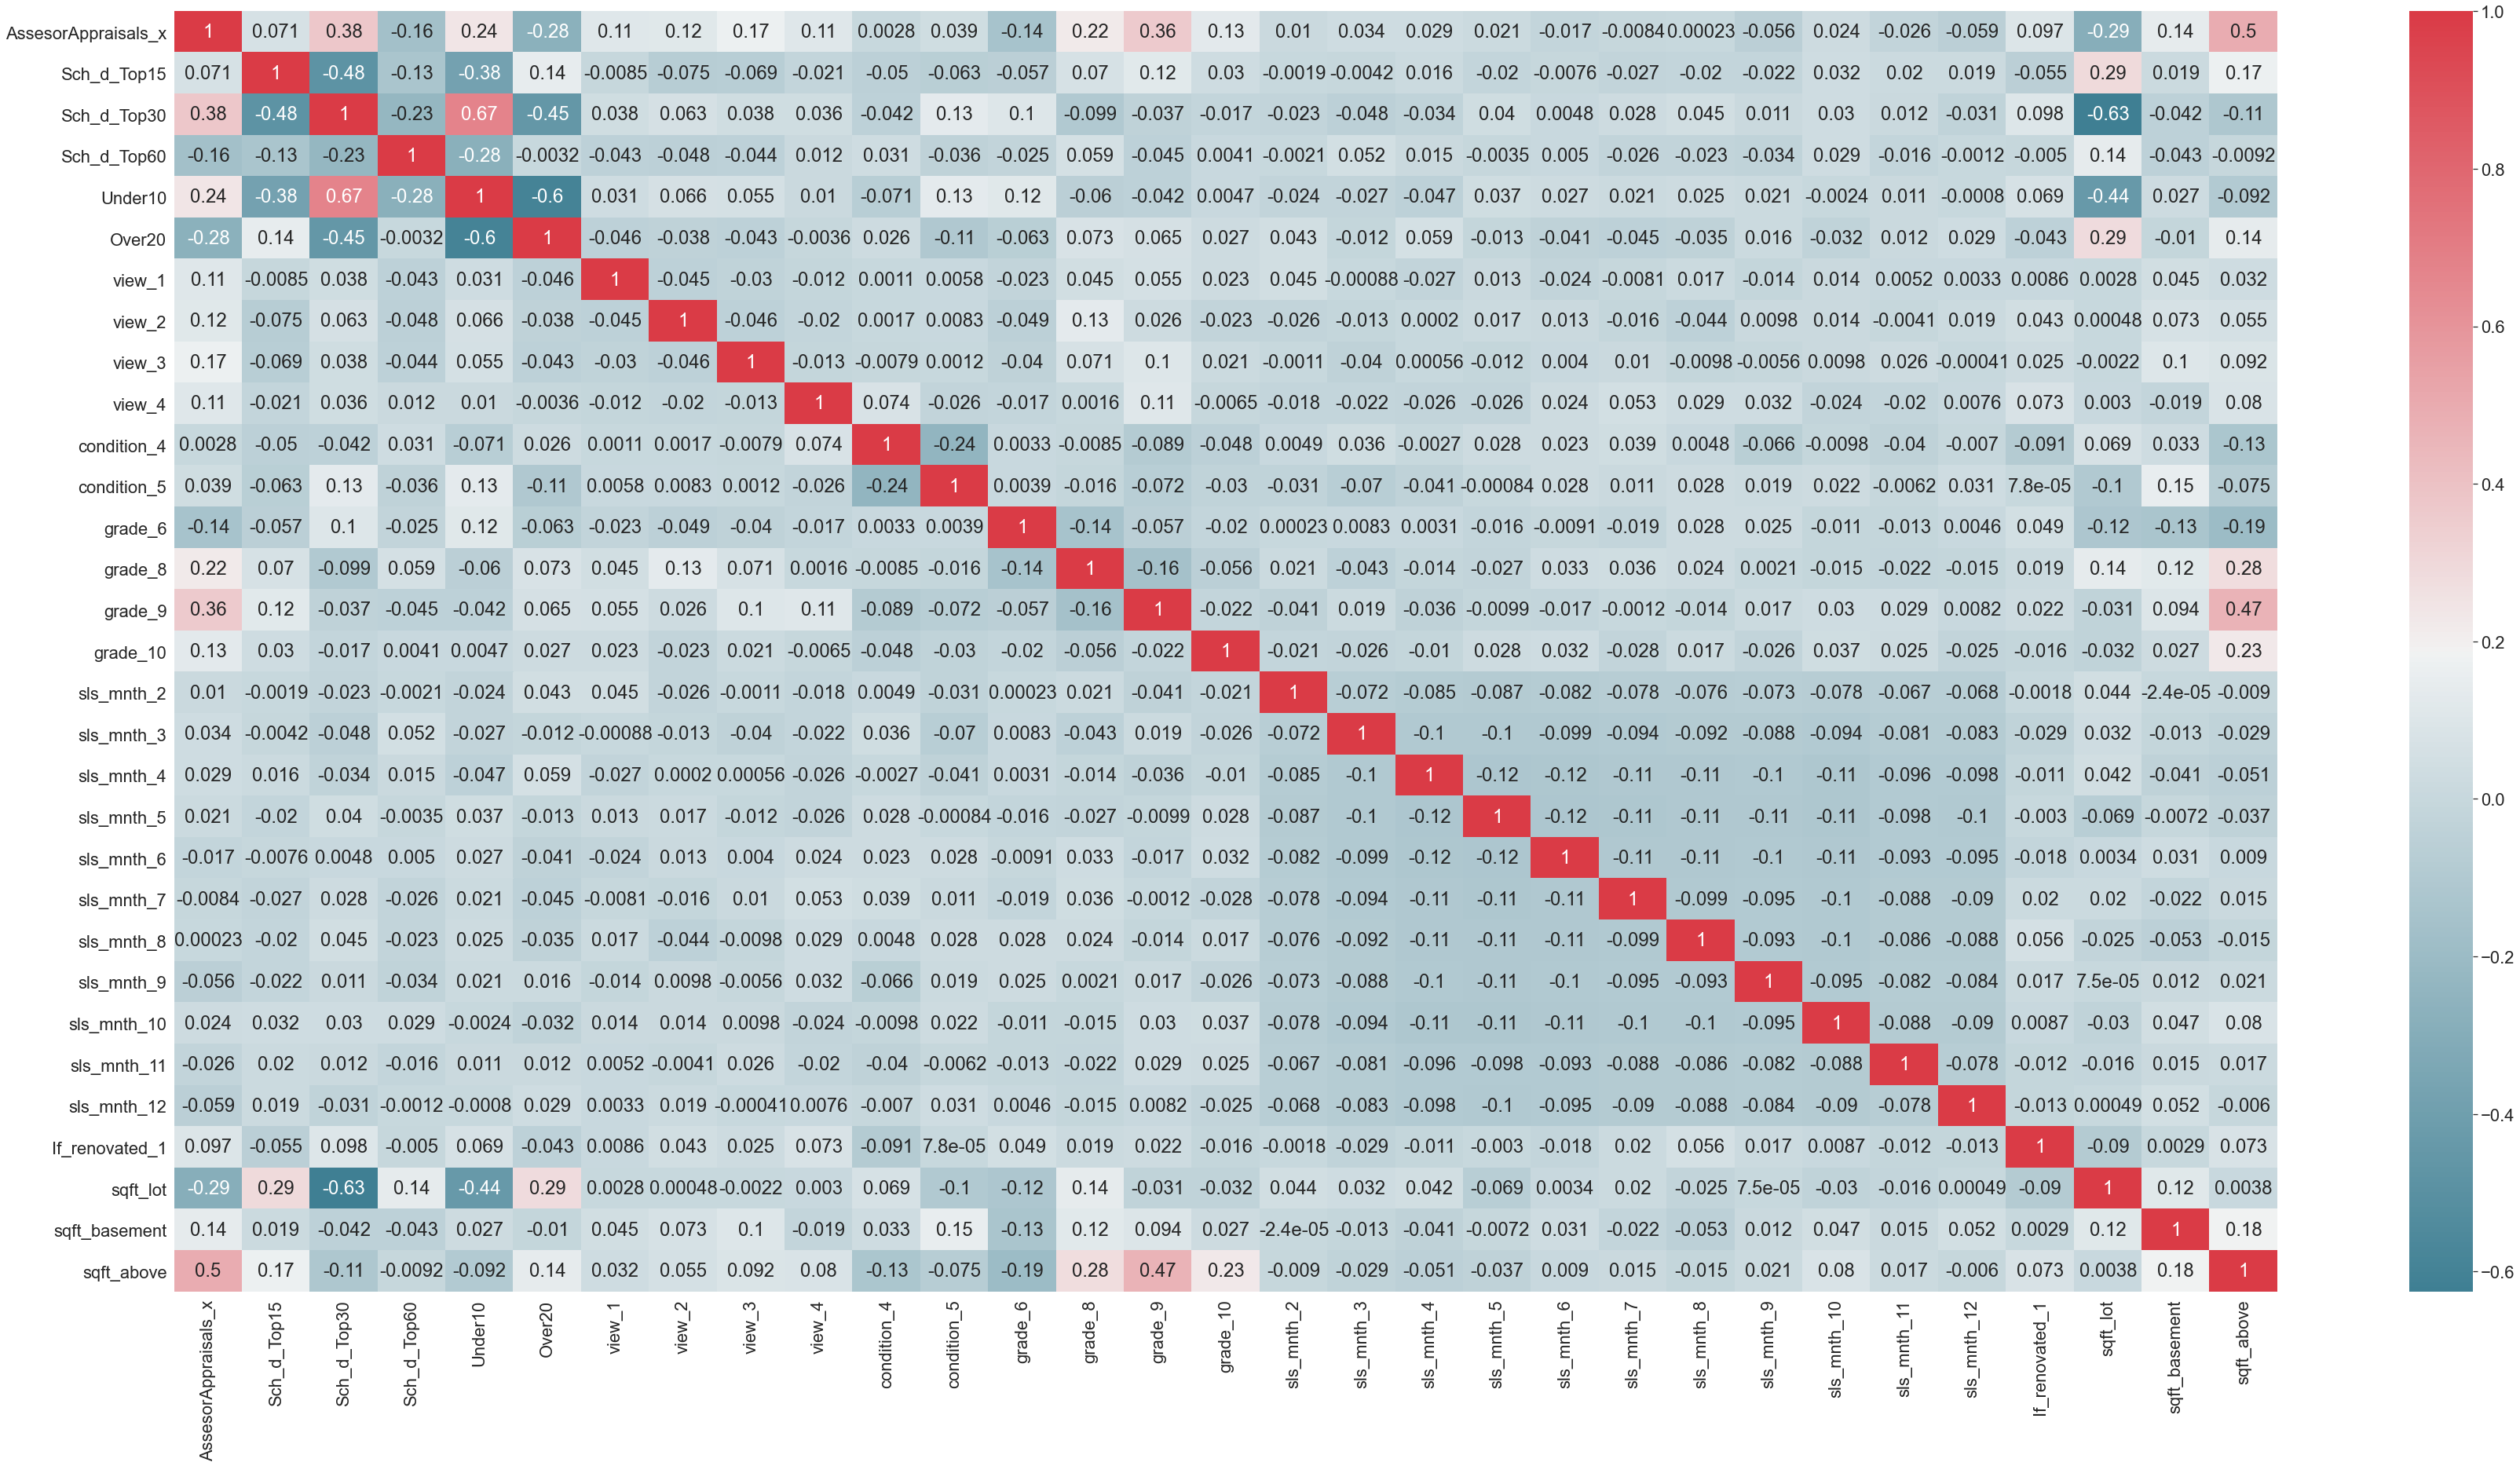

In [71]:
correlation_heatmap(data_Review_Colinearity_Model3)

## C. Create Pickle of Dataset

In [72]:
FieldsMovingForward = ['id','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']
FieldsMovingForward.extend(data_Review_Colinearity_Model3.columns)
df_data_with_Appraisals = df_data_with_Appraisals[FieldsMovingForward]

In [73]:
import pickle
# Save
with open('./data/PickleFiles/regression_Data_Third_Model.pickle', 'wb') as f:
    pickle.dump(df_data_with_Appraisals, f)

In [74]:
#Create Pickle of minmaxScaler
with open('./data/PickleFiles/scaler_3.pickle', 'wb') as f:
    pickle.dump(scaler_3, f)

with open('./data/PickleFiles/df_data_with_Appraisals.pickle', 'wb') as f:
    pickle.dump(df_data_with_Appraisals, f)

# Ensure linearity of All Features(independent) to target(dependent)

In [75]:
df_lastCheck = df_data_with_Appraisals.drop(columns=["id"])

In [ ]:
correlation_heatmap(df_lastCheck)